# MTG Deck builder

In [1]:
from langchain_ollama import ChatOllama, OllamaEmbeddings

llm = ChatOllama(model="llama3.1", num_ctx=8192)
embeddings = OllamaEmbeddings(model="snowflake-arctic-embed2")

In [2]:
from deep_mtg.tools import RulesRetriever, CardsRetriever

In [3]:
from pathlib import Path

rules_retriever = RulesRetriever(Path('../data/MagicCompRules 20241108.pdf'), embeddings=embeddings)
cards_retriever = CardsRetriever(Path('../data/cards'), llm=llm, embeddings=embeddings)

Loaded 1236 document splits.
Loading vectors from disk ../data/cards/cards.vec...


In [4]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import create_react_agent
import operator
from typing import Annotated, List, Literal, TypedDict, Optional

from langchain.chains.combine_documents.reduce import (
    acollapse_docs,
    split_list_of_docs,
)
from langchain_core.documents import Document
from langgraph.constants import Send
from langgraph.graph import END, START, StateGraph
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from pydantic import BaseModel, Field
import json

# class Card(BaseModel):
#     name: str = Field(description="Card name")
#     # type: Annotated[str, ..., "Card type"]
#     cost: Optional[str|int] = Field(default=None, description="Card cost, if applicable")
#     text: Optional[str] = Field(default=None, description="Card text, if applicable")
#     power: Optional[str|int] = Field(default=None, description="Card power, if applicable")
#     toughness: Optional[str|int] = Field(default=None, description="Card toughness, if applicable")

# class DeckState(BaseModel):
#     prompt: str = Field(description="Prompt for the deck")
#     cards: list[Card] = Field(description="List of cards in the deck")
#     n_cards: int = Field(description="Number of cards in the deck")
#     # n_lands: Annotated[int, 0, "Number of lands in the deck"]
#     # n_creatures: Annotated[int, 0, "Number of creatures in the deck"]
#     # n_other: Annotated[int, 0, "Number of other cards in the deck"]

class DeckCard(TypedDict):
    name: Annotated[str, ..., "Card name"]
    types: Annotated[str, ..., "Card type"]
    cost: Annotated[Optional[str], ..., "Card cost, including mana colors, if applicable"]
    text: Annotated[Optional[str], ..., "Card text, if applicable"]
    power: Annotated[Optional[int], ..., "Card power, if applicable"]
    toughness: Annotated[Optional[int], ..., "Card toughness, if applicable"]
    description: Annotated[str, ..., "High-level card description"]

# class QueryCard(TypedDict):
#     colours: Annotated[Optional[str], ..., "Mana colours of the card, if applicable"]
#     convertedManaCost: Annotated[int, ..., "Converted mana cost of the card, if applicable"]
#     keywords: Annotated[Optional[list[str]], ..., "List of keywords of the card, if applicable"]
#     manaCost: Annotated[str, ..., "Mana cost of the card, including colours, if applicable"]
#     name: Annotated[str, ..., "Card name"]
#     power: Annotated[int, ..., "Card power, if applicable"]
#     rarity: Annotated[str, ..., "Card rarity [Common, Uncommon, Rare, Mythic Rare]"]
#     subtypes: Annotated[Optional[list[str]], ..., "List of subtypes of the card, if applicable"]
#     text: Annotated[str, ..., "Card text, if applicable"]
#     toughness: Annotated[int, ..., "Card toughness, if applicable"]
#     types: Annotated[str, ..., "Card type"]

class DeckState(TypedDict):
    prompt: Annotated[str, ..., "Deck theme prompt"]
    cards: Annotated[list[DeckCard], [], "List of cards in the deck"]
    n_cards: Annotated[int, 0, "Number of cards in the deck"]
    n_lands: Annotated[int, 0, "Number of lands in the deck"]
    n_creatures: Annotated[int, 0, "Number of creatures in the deck"]
    n_enchantments: Annotated[int, 0, "Number of enchantments in the deck"]
    n_instants: Annotated[int, 0, "Number of instants in the deck"]
    n_sorceries: Annotated[int, 0, "Number of sorceries in the deck"]
    n_artifacts: Annotated[int, 0, "Number of artifacts in the deck"]
    n_other: Annotated[int, 0, "Number of other cards in the deck"]

In [12]:
from tqdm import tqdm
from collections import defaultdict

def append_card(deck_state: DeckState, card: DeckCard) -> DeckState:
    deck_state['cards'].append(card)
    deck_state['n_cards'] += 1
    if 'land' in card['types'] or 'Land' in card['types']:
        deck_state['n_lands'] += 1
    elif 'creature' in card['types'] or 'Creature' in card['types']:
        deck_state['n_creatures'] += 1
    elif 'enchantment' in card['types'] or 'Enchantment' in card['types']:
        deck_state['n_enchantments'] += 1
    elif 'instant' in card['types'] or 'Instant' in card['types']:
        deck_state['n_instants'] += 1
    elif 'sorcery' in card['types'] or 'Sorcery' in card['types']:
        deck_state['n_sorceries'] += 1
    elif 'artifact' in card['types'] or 'Artifact' in card['types']:
        deck_state['n_artifacts'] += 1
    else:
        deck_state['n_other'] += 1

    return deck_state

def build_deck(deck_state: DeckState) -> DeckState:
    deck_state = build_initial_manabase(deck_state, n=18)
    for _ in tqdm(range(60-24)):
        deck_state = add_card(deck_state)
    deck_state = build_final_manabase(deck_state)
    for _ in tqdm(range(60-deck_state['n_cards'])):
        deck_state = add_card(deck_state)
    return deck_state

card_tools_llm = llm.bind_tools([rules_retriever, cards_retriever])
card_advisor_llm = llm

class LandSelector(TypedDict):
    n_green: Annotated[int, ..., "Number of basic green lands to add"]
    n_blue: Annotated[int, ..., "Number of basic blue lands to add"]
    n_red: Annotated[int, ..., "Number of basic red lands to add"]
    n_white: Annotated[int, ..., "Number of basic white lands to add"]
    n_black: Annotated[int, ..., "Number of basic black lands to add"]
    n_green_white: Annotated[int, ..., "Number of green-white dual lands to add"]
    n_blue_white: Annotated[int, ..., "Number of blue-white dual lands to add"]
    n_black_white: Annotated[int, ..., "Number of black-white dual lands to add"]
    n_red_white: Annotated[int, ..., "Number of red-white dual lands to add"]
    n_green_blue: Annotated[int, ..., "Number of green-blue dual lands to add"]
    n_black_blue: Annotated[int, ..., "Number of black-blue dual lands to add"]
    n_red_blue: Annotated[int, ..., "Number of red-blue dual lands to add"]
    n_green_black: Annotated[int, ..., "Number of green-black dual lands to add"]
    n_red_black: Annotated[int, ..., "Number of red-black dual lands to add"]

land_selector_llm = llm.with_structured_output(LandSelector)

def build_initial_manabase(deck_state: DeckState, n: int) -> DeckState:
    prompt_template = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are an expert Magic: The Gathering deck builder. "
                "You are advising on building a high-competitative 60-card deck with a user-provided theme. "
                "You are working with a fellow expert deck builder to build a deck. "
                "Your role is to suggest the best combination of lands to form the initial manabase of the deck. "
                "You should add a total of {n_lands} lands to the deck. "
                "These can be basic lands or dual lands. "
                "Since you will be providing the initial manabase, you should consider the colour requirements of the deck given the theme. "
                "Your colleague will then add the remaining cards to the deck, after which you will be able to finalise the manabase of the deck. "
                "If no lands of a particular type are needed, you should output 0 for that type. "
                "Remeber that the more colors you add to the deck, the more dual lands you should include. "
                "When choosing which colors to include, consider the trade-off between ease of play of and card variety: more colors allow for more card variety, but make the deck harder to play. "
            ),
            (
                "user",
                "The deck theme is {prompt}. "
                "Please output how lands of each type I should add. "
            ),
        ]
    )

    backup_prompt_template = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are an expert Magic: The Gathering deck builder. "
                "You are advising on building a high-competitative 60-card deck with a user-provided theme. "
                "You are working with a fellow expert deck builder to build a deck. "
                "Your role is to suggest the best combination of mana colors to form the initial manabase of the deck given the theme. "
                "You should only output the mana colors, and not any other information. "
                "\n"
                "Examples:\n"
                "- life-gain vampires: black and white\n"
                "- goblin tribal: red\n"
                "- Azorius control: blue and white\n"
                "- mono-green elves: green\n"
                "- Rakdos sacrifice: black and red\n"
                "- Izzet spells: blue and red\n"
                "- Grixis control: blue, black, and red\n"
                "- Sultai midrange: black, green, and blue\n"
                "- Jeskai control: blue, white, and red\n"
            ),
            (
                "user",
                "The deck theme is {prompt}. "
                "Please output the mana colors I should use. "
            ),
        ]
    )

    response = None
    fails = 0
    while response is None:
        if fails > 5:
            print('Failed to correctly output the initial manabase after 5 attempts, relaxing constraints')
            n_colors = 0
            while n_colors == 0:
                backup_response = llm.invoke(backup_prompt_template.invoke({"prompt": deck_state['prompt'],"n_lands": n})).content.lower()
                colors = []
                for color in ['green', 'red', 'black', 'blue', 'white']:
                    if color in backup_response:
                        colors.append(color)
                n_colors = len(colors)
            
            response = LandSelector(n_green=0, n_blue=0, n_red=0, n_white=0, n_black=0, n_green_white=0, n_blue_white=0, n_black_white=0, n_red_white=0, n_green_blue=0, n_black_blue=0, n_red_blue=0, n_green_black=0, n_red_black=0, n_other=0)     
            if n_colors == 1:
                n_each = n
                n_duals = 0
            else:
                n_duals = 3
                n_each = (n-n_duals) // n_colors

            for i in range(n_colors):
                response[f'n_{colors[i]}'] = n_each
                for j in range(i+1, n_colors):
                    response[f'n_{colors[i]}_{colors[j]}'] = n_duals         
            break

        # response = land_selector_llm.invoke(prompt_template.invoke({"prompt": deck_state['prompt'], "n_lands": n}))
        fails += 1

    print('Initial manabase:', response)
    for count in response:
        land = count[2:]
        for _ in range(response[count]):
            deck_state = append_card(deck_state, DeckCard(name=f'{land} land', types=['land'], cost=None, text=f'{land} land', power=0, toughness=0, description=f'{land} land'))

    return deck_state

class NLandsResponse(TypedDict):
    n_lands: Annotated[int, ..., "Number of lands to add"]

n_lands_llm = llm.with_structured_output(NLandsResponse)
    
def build_final_manabase(deck_state: DeckState) -> DeckState:
    n_lands_query_prompt_template = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are an expert Magic: The Gathering deck builder. "
                "You are advising on building a high-competitative 60-card deck with a user-provided theme. "
                "You are working with a fellow expert deck builder to build a deck. "
                "They have put together a deck with a total of {n_cards} cards, {n_lands} lands, {n_creatures} creatures, and {n_other} other cards. "
                "Your role is to finalize manabase of the deck by suggesting how many more lands should be added. "
                "To do this, you should consider the current state of the deck, the metagame, and the deck theme. "
                "Most 60-card decks run between 20 and 26 lands, with 24 being standard. "
                "However, the exact number of lands can vary depending on the deck's theme and strategy. "
                "Cheaper, faster decks may run fewer lands, while slower, more expensive decks may run more lands. "
                "Remaining slots after adding the number of lands you suggest will be filled with other cards. "
            ),
            (
               "user",
                "The deck theme is {prompt}. "
                "The current deck consists of {n_cards} cards, {n_lands} lands, {n_creatures} creatures, and {n_other} other cards. "
                "The cards present are:\n{deck}.\n "
                "Please suggest how many more lands should be added. "
            ),
        ]
    )
    
    n_remaining_lands = None
    fails = 0
    while n_remaining_lands is None:
        if fails > 5:
            print('Failed to correctly output the number of lands after 5 attempts, setting total lands to 24')
            n_remaining_lands = 24-deck_state['n_lands']
            break
        response = n_lands_llm.invoke(n_lands_query_prompt_template.invoke({"prompt": deck_state['prompt'], "n_cards": deck_state['n_cards'], "n_lands": deck_state['n_lands'], "n_creatures": deck_state['n_creatures'],
                                                                                      "n_other": deck_state['n_other'], "deck": get_deck_list(deck_state)[1]}))
        if response is not None:
            n_remaining_lands = response['n_lands']
        if n_remaining_lands < 0 or n_remaining_lands > 60-deck_state['n_cards']:
            n_remaining_lands = None
        fails += 1

    print('Number of lands to add:', n_remaining_lands)

    land_query_prompt_template = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are an expert Magic: The Gathering deck builder. "
                "You are advising on building a high-competitative 60-card deck with a user-provided theme. "
                "You are working with a fellow expert deck builder to build a deck. "
                "They have put together a prototype deck, and your role is to finalize manabase of the deck by incrementally adding lands. "
                "You will do this by describing the next land to be added to the deck. "
                "The desired card doesn't need to actually exist in the game, I will find the closest card that matches your description. "
                "\n"
                "Example descriptions: "
                '\nA dual land that taps for green and white mana and can be used to fix your mana base'
                '\nA land that can produce creature tokens'
                '\nA land that can be sacrificed to search for another card'
                '\nA land can attack and block like a creature'
                "\n"
                "Only describe one card at a time. "
                "Do not return anything other than the description of the card. "
                "Do not mention the name of the card or the theme of the deck. "
                "Please also describe its role in the deck. "
                "Rather than quantifying attributes of the card, instead use qualitative terms like 'strong' or 'weak' to describe the card. "
                "\n"
                "When choosing the card, consider the following: "
                "\n1. The card should be a good fit for the deck theme. "
                "\n2. The card should be a good fit for the current state of the deck. "
                "\n3. The card should be a good fit for the current metagame. "
                "\n4. What is the card's role in the deck? "
                "\n5. What is the card's impact on the game? "
                "\n6. What is the card's synergy with other cards in the deck? "
                "\n7. What is the card's synergy with the deck's strategy? "
                "\n8. What current weaknesses in the deck does the card address? "
                "\n9. What current strengths in the deck does the card enhance? "
            ),
            (
               "user",
                "The deck theme is {prompt}. "
                "The current deck consists of {n_cards} cards, {n_lands} lands, {n_creatures} creatures, and {n_other} other cards. "
                "The cards present are:\n{deck}.\n "
                "In total, you will be able to add in {n_remaining_lands} more lands to the deck, inclduing this one. "
                "Please give a description of what land card should be added to the deck. "
            ),
        ]
    )

    for _ in tqdm(range(n_remaining_lands)):
        desired_card = llm.invoke(land_query_prompt_template.invoke({"prompt": deck_state['prompt'], "n_cards": deck_state['n_cards'], "n_lands": deck_state['n_lands'], "n_creatures": deck_state['n_creatures'], "n_other": deck_state['n_other'], 
                                                                     "deck": get_deck_list(deck_state)[1], 
                                                                "n_remaining_lands": n_remaining_lands})).content
        print('Recommended card:', desired_card)
        card = search_card(deck_state, desired_card)
        deck_state = append_card(deck_state, card)
        n_remaining_lands -= 1

    return deck_state


def get_deck_list(deck_state: DeckState) -> tuple[dict[dict[str, int]], str]:
    deck_contents = defaultdict(lambda: defaultdict(int))
    type_counts = defaultdict(int)
    for card in deck_state['cards']:
        entry = f"{card['name']}: {card['description']}"
        types = ','.join(card['types']).lower()
        if 'land' in types:
            deck_contents['lands'][entry] += 1
            type_counts['lands'] += 1
        elif 'creature' in types:
            deck_contents['creatures'][entry] += 1
            type_counts['creatures'] += 1
        elif 'sorcery' in types:
            deck_contents['sorceries'][entry] += 1
            type_counts['sorceries'] += 1
        elif 'instant' in types:
            deck_contents['instants'][entry] += 1
            type_counts['instants'] += 1
        elif 'enchantment' in types:
            deck_contents['enchantments'][entry] += 1
            type_counts['enchantments'] += 1
        elif 'artifact' in types:
            deck_contents['artifacts'][entry] += 1
            type_counts['artifacts'] += 1
        else:
            deck_contents['other'][entry] += 1
            type_counts['other'] += 1
        
    deck_str = ''
    for card_type, cards in deck_contents.items():
        deck_str += f'\n## {card_type}: {type_counts[card_type]}'
        for card, count in cards.items():
            deck_str += f'\n- {count} x {card}'
    deck_str += '\n'

    return deck_contents, deck_str

def add_card(deck_state: DeckState) -> DeckState:
    prompt = deck_state['prompt']
    if deck_state['n_cards'] == 0:
        prompt = prompt + ' but it is currently empty'

    deck_contents, deck_str = get_deck_list(deck_state)
    print('Current deck:', deck_str)

    card_advisor_prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are an expert Magic: The Gathering deck builder. "
                "You are advising on building a high-competitative 60-card deck with a user-provided theme. "
                "Given the current state of the deck, provide a high-level description of what card should be added next. "
                "If the deck is empty, suggest a starting card that would be a good fit for the theme. "
                "The desired card doesn't need to actually exist in the game, I will find the closest card that matches your description. "
                "\n"
                "Example descriptions: "
                '\nA cheap, weak, red creature with flying and haste that can be played early in the game'
                '\nA 3-4 mana white sorcery that destroys all creatures which can be used to clear the board in the mid-game'
                '\nA costly blue sorcery that lets you draw multiple cards and can be used to refill your hand in the late game'
                '\nA land that taps for green or black mana and can be used to fix your mana base and to surveil when played'    
                "\n"
                "Only describe one card at a time. "
                "Do not return anything other than the description of the card. "
                "Do not mention the name of the card or the theme of the deck. "
                "Please also describe its role in the deck. "
                "Rather than quantifying attributes of the card, instead use qualitative terms like 'strong' or 'weak' to describe the card. "
                "Remember, the deck should have 60 cards, including lands. "
                "\n"
                "When choosing the card, consider the following: "
                "\n1. The card should be a good fit for the deck theme. "
                "\n2. The card should be a good fit for the current state of the deck. "
                "\n3. The card should be a good fit for the current metagame. "
                "\n4. What is the card's role in the deck? "
                "\n5. What is the card's impact on the game? "
                "\n6. What is the card's synergy with other cards in the deck? "
                "\n7. What is the card's synergy with the deck's strategy? "
                "\n8. What current weaknesses in the deck does the card address? "
                "\n9. What current strengths in the deck does the card enhance? "
                "\n10. What is the card's mana cost and colour? "
                "\n11. Can the card be cast using the current manabase, or via other effects (e.g. reanimation)?"
                "\n"
                # "You can use the CardsRetriever tool to find cards that match the description. "
            ),
            (
                "user",
                "The deck theme is {prompt}. "
                "The current deck consists of {n_cards} cards, {n_lands} lands, {n_creatures} creatures, and {n_other} other cards. "
                "The cards present are:\n{deck}.\n "
                "Please give a description of what card should be added to the deck. "
            ),
        ]
    )
    desired_card = card_advisor_llm.invoke(card_advisor_prompt.invoke({"prompt": deck_state['prompt'], 
                                 "n_cards": deck_state['n_cards'], 
                                 "n_lands": deck_state['n_lands'],
                                   "n_creatures": deck_state['n_creatures'],
                                     "n_other": deck_state['n_other'], 
                                     "deck": deck_str})
            ).content
        
    print('Recommended card:', desired_card)
    card = search_card(deck_state, desired_card)
    deck_state = append_card(deck_state, card)
    return deck_state

class ZeroIndexCardSelection(TypedDict):
    index: Annotated[int, ..., "Zero-indexed index of the card to be added"]
    reason: Annotated[Optional[str], ..., "Reason for selecting the card"]

card_selector_llm = llm.with_structured_output(ZeroIndexCardSelection)

def search_card(deck_state: DeckState, desired_card: str) -> DeckCard:
    '''
    TODO: Add metadata filtering
    '''

    deck_contents, deck_str = get_deck_list(deck_state)
    k = 5
    matching_cards = []
    while len(matching_cards) < 5:
        matching_cards = cards_retriever.invoke({'query': desired_card, 'k':k})
        matching_cards_dicts = [json.loads(c) for c in matching_cards]
        # filter out cards that are already in the deck 4 times
        matching_cards = [c for i,c in enumerate(matching_cards) if f'4 x {matching_cards_dicts[i]["name"]}' not in deck_str]
        k += max(1, 5 - len(matching_cards))
    
    matching_cards_dicts = [json.loads(c) for c in matching_cards]  # recreate in case of filtering
    matching_cards_str = '\n'.join([f'index {i}: {c['summary']}' for i,c in enumerate(matching_cards_dicts)])
    print('Matching cards:', matching_cards_str)

    card_selector_prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are an expert Magic: The Gathering deck builder. "
                "You are advising on building a high-competitative 60-card deck with a user-provided theme. "
                "You are working with a fellow expert deck builder to build a deck. "
                "Your colleague has provided a high-level description of a card that should be added to the deck. "
                "You will be provided with a list of cards that match the description. "
                "You need to select the best card to add to the deck. "
                "The card should be a good fit for the deck theme, the current state of the deck, and the current metagame. "
                "Remeber that a deck cannot have more than 4 copies of a card, unless it is a basic land. "
                "Also consider the manabase of the deck when choosing the card. "
                "However, also consider that the deck may be able to cards not in the current manabase via reanimation effects, etc. "
                
                "\n"
                "When choosing the card, consider the following: "
                "\n1. The card should be a good fit for the deck theme. "
                "\n2. The card should be a good fit for the current state of the deck. "
                "\n3. The card should be a good fit for the current metagame. "
                "\n4. What is the card's role in the deck? "
                "\n5. What is the card's impact on the game? "
                "\n6. What is the card's synergy with other cards in the deck? "
                "\n7. What is the card's synergy with the deck's strategy? "
                "\n8. What current weaknesses in the deck does the card address? "
                "\n9. What current strengths in the deck does the card enhance? "
                "\n10. What is the card's mana cost and colour? "
                "\n"
            ),
            (
                "user",
                "The deck theme is {prompt}. "
                "The current deck consists of {n_cards} cards, {n_lands} lands, {n_creatures} creatures, and {n_other} other cards. "
                "The cards present are:\n{deck}.\n"
                "The description of the card that should be added to the deck is: {description}. "
                "The list of cards that match the description is:\n{cards}.\n"
                "Please output the index of the card to be added, using zero-indexing. "
            ),
        ]
    )
    selector_response = None
    card_index = None
    fails = 0
    while selector_response is None:
        if fails > 5:
            print('Failed to correctly select a card after 5 attempts, selecting the zeroth card')
            card_index = 0
            break
        selector_response = card_selector_llm.invoke(card_selector_prompt.invoke({"prompt": deck_state['prompt'],
                                                                    "n_cards": deck_state['n_cards'], 
                                     "n_lands": deck_state['n_lands'],
                                       "n_creatures": deck_state['n_creatures'],
                                         "n_other": deck_state['n_other'], 
                                            "cards": matching_cards_str,
                                        "deck": deck_str,
                                        "description": desired_card})
                )
        if selector_response is not None and selector_response['index'] > len(matching_cards):
            selector_response = None
        fails += 1
    if card_index is None:
        card_index = selector_response['index']
        print(f'Selected card index: {card_index}, reason: {selector_response["reason"]}')
        
    card = matching_cards[card_index]
    print('Matching card:', card)
    
    card = json.loads(card)
    return DeckCard(name=card['name'],
                 types=card['types'],
                   cost=card['manaCost'], 
                   text=card['text'], 
                   power=card['power'],
                     toughness=card['toughness'],
                     description=card['summary'])

In [13]:
add_card(
    DeckState(prompt="a black creature-focussed deck built around zombies", cards=[], n_cards=0, 
                   n_lands=0, n_creatures=0, n_other=0
                   )
)

Current deck: 

Recommended card: A strong, low-toughness black creature that can deal damage quickly when played early in the game, likely generating card advantage or additional threats when it dies.

 Role: Early-game threat and potential tempo generator. 

 Impact: The card's presence will allow the player to start attacking early and potentially generate card advantage through death triggers.
Matching cards: index 0: Tragic Banshee: This strong black creature is a removal spell in disguise. Its high power and moderate toughness make it a formidable attacker, but its true value lies in its ability to apply massive damage to opponents' creatures when they die, making it a key part of a mid-game strategy. The 5 mana cost is moderately expensive for a black creature, indicating that this card rewards careful planning and can be a game-changer with the right setup.
index 1: Stab is a Black Instant that weakens a target creature's power and toughness for one turn. It's cheap to play, ma

{'prompt': 'a black creature-focussed deck built around zombies',
 'cards': [{'name': 'Tragic Banshee',
   'types': ['Creature'],
   'cost': '{4}{B}',
   'text': 'Morbid — When this creature enters, target creature an opponent controls gets -1/-1 until end of turn. If a creature died this turn, that creature gets -13/-13 instead.',
   'power': '5',
   'toughness': '3',
   'description': "Tragic Banshee: This strong black creature is a removal spell in disguise. Its high power and moderate toughness make it a formidable attacker, but its true value lies in its ability to apply massive damage to opponents' creatures when they die, making it a key part of a mid-game strategy. The 5 mana cost is moderately expensive for a black creature, indicating that this card rewards careful planning and can be a game-changer with the right setup."}],
 'n_cards': 1,
 'n_lands': 0,
 'n_creatures': 1,
 'n_other': 0}

In [14]:
build_initial_manabase(
    DeckState(prompt="a black creature-focussed deck built around zombies, but with the potential to disrupt the opponent", cards=[], n_cards=0, 
                   n_lands=0, n_creatures=0, n_other=0
                   ), n=18
)

Failed to correctly output the initial manabase after 5 attempts, relaxing constraints
Initial manabase: {'n_green': 0, 'n_blue': 0, 'n_red': 7, 'n_white': 0, 'n_black': 7, 'n_green_white': 0, 'n_blue_white': 0, 'n_black_white': 0, 'n_red_white': 0, 'n_green_blue': 0, 'n_black_blue': 0, 'n_red_blue': 0, 'n_green_black': 0, 'n_red_black': 3, 'n_other': 0}


{'prompt': 'a black creature-focussed deck built around zombies, but with the potential to disrupt the opponent',
 'cards': [{'name': 'red land',
   'types': ['land'],
   'cost': None,
   'text': 'red land',
   'power': 0,
   'toughness': 0,
   'description': 'red land'},
  {'name': 'red land',
   'types': ['land'],
   'cost': None,
   'text': 'red land',
   'power': 0,
   'toughness': 0,
   'description': 'red land'},
  {'name': 'red land',
   'types': ['land'],
   'cost': None,
   'text': 'red land',
   'power': 0,
   'toughness': 0,
   'description': 'red land'},
  {'name': 'red land',
   'types': ['land'],
   'cost': None,
   'text': 'red land',
   'power': 0,
   'toughness': 0,
   'description': 'red land'},
  {'name': 'red land',
   'types': ['land'],
   'cost': None,
   'text': 'red land',
   'power': 0,
   'toughness': 0,
   'description': 'red land'},
  {'name': 'red land',
   'types': ['land'],
   'cost': None,
   'text': 'red land',
   'power': 0,
   'toughness': 0,
   'desc

In [47]:
build_final_manabase(
    DeckState(prompt="a black creature-focussed deck built around zombies, but with the potential to disrupt the opponent", cards=[], n_cards=0, 
                   n_lands=0, n_creatures=0, n_other=0
                   )
)

Number of lands to add: 24


  0%|          | 0/24 [00:00<?, ?it/s]

Recommended card: I would like to add a strong, versatile dual land that can fix mana for both black and a secondary color, which will provide flexibility for casting creatures later in the game.
Matching cards: index 0: Swamp is a weak, color-fixing basic land that provides black mana. It's simple and straightforward, allowing you to add one black mana to your pool for a low cost.
index 1: Plains is a strong land that provides colorless mana for white spells. It's extremely cheap with an empty or weak mana cost, and its ability to add one mana of a specific color (white) is very reliable.
index 2: Secluded Courtyard is a strong land that provides multiple colors of mana through its abilities, allowing for flexible and efficient casting of creature spells. Its low mana cost is easy to pay, but it doesn't generate any card advantage or direct damage on its own. The ability to choose a specific creature type gives it versatility in supporting various strategies.
index 3: Orzhov Guildgate

  4%|▍         | 1/24 [00:03<01:17,  3.37s/it]

Selected card index: 2, reason: The deck theme is a black creature-focussed deck built around zombies, but with the potential to disrupt the opponent, and Secluded Courtyard is a strong land that provides multiple colors of mana through its abilities, allowing for flexible and efficient casting of creature spells.
Matching card: {"summary": "Secluded Courtyard is a strong land that provides multiple colors of mana through its abilities, allowing for flexible and efficient casting of creature spells. Its low mana cost is easy to pay, but it doesn't generate any card advantage or direct damage on its own. The ability to choose a specific creature type gives it versatility in supporting various strategies.", "colors": [], "convertedManaCost": 0, "keywords": null, "manaCost": null, "name": "Secluded Courtyard", "power": null, "rarity": "uncommon", "subtypes": [], "supertypes": [], "text": "As this land enters, choose a creature type.\n{T}: Add {C}.\n{T}: Add one mana of any color. Spend th

  8%|▊         | 2/24 [00:05<00:54,  2.49s/it]

Selected card index: 4, reason: A strong and versatile dual land that provides both black and other colors of mana would be beneficial for the current state of the deck. A land that allows us to cast our potential zombies at an accelerated rate, while also giving flexibility in case we choose to disrupt the opponent later on, is a good fit.
Matching card: {"summary": "Crawling Barrens is a strong land card with the potential to impact gameplay through its multiple abilities. Its mana cost is low and inexpensive, allowing it to be played early in the game. The card has a versatile text ability that lets you add one mana of any color when tapped. Additionally, for four colorless mana, it can gain two +1/+1 counters, making it more valuable over time, and also transform into a 0/0 Elemental creature until end of turn if desired, showcasing its land's secondary use as a potential combat threat.", "colors": [], "convertedManaCost": 0, "keywords": null, "manaCost": null, "name": "Crawling Ba

 12%|█▎        | 3/24 [00:06<00:44,  2.11s/it]

Selected card index: 0, reason: The Forest land provides a low-cost source of green mana, improving mana fixing and generating more card advantage over time.
Matching card: {"summary": "Forest: This is a very strong and simple land card. It's a key part of the game for any green deck, providing a low-cost source of mana. The ability to add green mana without tapping it makes Forest a valuable addition to early-game strategies. Overall, Forest is a weak card on its own but crucial for supporting more powerful spells. (Colorless)", "colors": [], "convertedManaCost": 0, "keywords": null, "manaCost": null, "name": "Forest", "power": null, "rarity": "common", "subtypes": ["Forest"], "supertypes": ["Basic"], "text": "({T}: Add {G}.)", "toughness": null, "types": ["Land"]}
Recommended card: A strong, efficient land that can produce multiple colors of mana is needed to complement Secluded Courtyard and Crawling Barrens. The new land should have a low-to-moderate mana cost, allowing it to be pl

 17%|█▋        | 4/24 [00:08<00:41,  2.09s/it]

Selected card index: 2, reason: The deck needs a land that can produce multiple colors of mana and has a low-to-moderate mana cost. Scoured Barrens fits these requirements as it is an efficient land that provides moderate to high level of mana fixing, is easy to play early in the game, and gains 1 life when it enters.
Matching card: {"summary": "Scoured Barrens is a strong common land card that provides a moderate to high level of mana fixing. Its mana cost is essentially free, making it easy to play early in the game. The card's ability to gain 1 life when it enters also gives some defensive value. It can add either white or black mana, which are both relatively stable colors.", "colors": [], "convertedManaCost": 0, "keywords": null, "manaCost": null, "name": "Scoured Barrens", "power": null, "rarity": "common", "subtypes": [], "supertypes": [], "text": "This land enters tapped.\nWhen this land enters, you gain 1 life.\n{T}: Add {W} or {B}.", "toughness": null, "types": ["Land"]}
Reco

 21%|██        | 5/24 [00:10<00:34,  1.84s/it]

Selected card index: 1, reason: The Swamp provides black mana and is a good fit for the deck theme
Matching card: {"summary": "Swamp is a weak, color-fixing basic land that provides black mana. It's simple and straightforward, allowing you to add one black mana to your pool for a low cost.", "colors": [], "convertedManaCost": 0, "keywords": null, "manaCost": null, "name": "Swamp", "power": null, "rarity": "common", "subtypes": ["Swamp"], "supertypes": ["Basic"], "text": "({T}: Add {B}.)", "toughness": null, "types": ["Land"]}
Recommended card: A land that provides black and white mana fixability, has moderate toughness to withstand some early-game damage, and could potentially generate card advantage through its ability. The land's ability should also have some degree of synergy with the black creature-focussed strategy. 

It should be able to add both colors of the deck's primary color pair without creating unnecessary complexity or requiring too much setup time.
Matching cards: index

 25%|██▌       | 6/24 [00:12<00:34,  1.94s/it]

Selected card index: 3, reason: Cryptic Caves fits well with the deck theme as a land that provides black and white mana fixability through its activated ability, has moderate toughness to withstand some early-game damage, and can generate card advantage through its enchanted lands interaction. It is also easy to play with no color cost and adds value when you have a large number of lands in play.
Matching card: {"summary": "Cryptic Caves is an enchantment-advantage type of land card with no color cost, making it easy to play. It serves as a mana fixer and provides additional value through its activated ability. The card is relatively weak on its own but becomes strong when you have a large number of lands in play.", "colors": [], "convertedManaCost": 0, "keywords": null, "manaCost": null, "name": "Cryptic Caves", "power": null, "rarity": "uncommon", "subtypes": [], "supertypes": [], "text": "{T}: Add {C}.\n{1}, {T}, Sacrifice this land: Draw a card. Activate only if you control five o

 29%|██▉       | 7/24 [00:14<00:31,  1.87s/it]

Selected card index: 1, reason: The land should have no additional abilities or text effects beyond its mana production to keep the overall strategy of the deck focused on creature plays.
Matching card: {"summary": "Swamp is a weak, color-fixing basic land that provides black mana. It's simple and straightforward, allowing you to add one black mana to your pool for a low cost.", "colors": [], "convertedManaCost": 0, "keywords": null, "manaCost": null, "name": "Swamp", "power": null, "rarity": "common", "subtypes": ["Swamp"], "supertypes": ["Basic"], "text": "({T}: Add {B}.)", "toughness": null, "types": ["Land"]}
Recommended card: A basic, high-toughness land that provides green and black mana at a low cost, allowing for consistent creature casting while not being overly impactful on its own. It should also provide some defensive value due to its higher toughness compared to other lands in the deck.
Matching cards: index 0: Forest: This is a very strong and simple land card. It's a key

 33%|███▎      | 8/24 [00:15<00:27,  1.73s/it]

Selected card index: 3, reason: The Swamp provides black mana at a low cost, making it a good fit for the deck theme and current state.
Matching card: {"summary": "Swamp is a weak, color-fixing basic land that provides black mana. It's simple and straightforward, allowing you to add one black mana to your pool for a low cost.", "colors": [], "convertedManaCost": 0, "keywords": null, "manaCost": null, "name": "Swamp", "power": null, "rarity": "common", "subtypes": ["Swamp"], "supertypes": ["Basic"], "text": "({T}: Add {B}.)", "toughness": null, "types": ["Land"]}
Recommended card: The next land to be added to the deck is a strong basic land that provides black mana and has no inherent drawbacks or weaknesses. It's essential for supporting the deck's aggressive strategy and providing a consistent source of color-fixing, particularly in the early game. This land should be relatively inexpensive to play and allow for flexible casting of creature spells.
Matching cards: index 0: Forest: Thi

 38%|███▊      | 9/24 [00:17<00:25,  1.70s/it]

Selected card index: 1, reason: The deck needs a strong basic land that provides black mana and has no inherent drawbacks or weaknesses, so Swamp is the best fit
Matching card: {"summary": "Swamp is a weak, color-fixing basic land that provides black mana. It's simple and straightforward, allowing you to add one black mana to your pool for a low cost.", "colors": [], "convertedManaCost": 0, "keywords": null, "manaCost": null, "name": "Swamp", "power": null, "rarity": "common", "subtypes": ["Swamp"], "supertypes": ["Basic"], "text": "({T}: Add {B}.)", "toughness": null, "types": ["Land"]}
Recommended card: I'd like to add a land that can provide both black and red mana, allowing for additional flexibility in casting creature spells that require these colors. It would also benefit from having some level of removal or disruption potential, rather than just being a simple fixer card. The added card should be able to impact gameplay on its own, rather than just generating value over time li

 42%|████▏     | 10/24 [00:19<00:25,  1.79s/it]

Selected card index: 1, reason: The deck needs a land that can provide both black and red mana, allowing for additional flexibility in casting creature spells that require these colors. Crawling Barrens has the ability to add one mana of any color when tapped, making it a versatile choice.
Matching card: {"summary": "Crawling Barrens is a strong land card with the potential to impact gameplay through its multiple abilities. Its mana cost is low and inexpensive, allowing it to be played early in the game. The card has a versatile text ability that lets you add one mana of any color when tapped. Additionally, for four colorless mana, it can gain two +1/+1 counters, making it more valuable over time, and also transform into a 0/0 Elemental creature until end of turn if desired, showcasing its land's secondary use as a potential combat threat.", "colors": [], "convertedManaCost": 0, "keywords": null, "manaCost": null, "name": "Crawling Barrens", "power": null, "rarity": "rare", "subtypes":

 46%|████▌     | 11/24 [00:21<00:23,  1.80s/it]

Selected card index: 2, reason: The selected land, Blossoming Sands, provides life gain and additional mana generation when it enters the battlefield, addressing current weaknesses in the deck related to card advantage and mana fixing.
Matching card: {"summary": "Blossoming Sands is a weak land card that helps its controller maintain a steady supply of green and white mana. It's a bit tricky to play because it enters the battlefield tapped, but it has some nice benefits: it gains you one life when it enters and allows you to add one green or white mana whenever you pay one mana.", "colors": [], "convertedManaCost": 0, "keywords": null, "manaCost": null, "name": "Blossoming Sands", "power": null, "rarity": "common", "subtypes": [], "supertypes": [], "text": "This land enters tapped.\nWhen this land enters, you gain 1 life.\n{T}: Add {G} or {W}.", "toughness": null, "types": ["Land"]}
Recommended card: The next land to be added is a dual land that taps for black and green mana, providing

 50%|█████     | 12/24 [00:23<00:22,  1.89s/it]

Selected card index: 2, reason: The next land to be added is a dual land that taps for black and green mana, providing a strong foundation for casting creatures and generating life gain through its abilities.
Matching card: {"summary": "Crawling Barrens is a strong land card with the potential to impact gameplay through its multiple abilities. Its mana cost is low and inexpensive, allowing it to be played early in the game. The card has a versatile text ability that lets you add one mana of any color when tapped. Additionally, for four colorless mana, it can gain two +1/+1 counters, making it more valuable over time, and also transform into a 0/0 Elemental creature until end of turn if desired, showcasing its land's secondary use as a potential combat threat.", "colors": [], "convertedManaCost": 0, "keywords": null, "manaCost": null, "name": "Crawling Barrens", "power": null, "rarity": "rare", "subtypes": [], "supertypes": [], "text": "{T}: Add {C}.\n{4}: Put two +1/+1 counters on this

 54%|█████▍    | 13/24 [00:24<00:19,  1.81s/it]

Selected card index: 2, reason: The deck needs a basic dual land that provides black and red mana to fix its current lack of red sources and provide flexibility for future additions.
Matching card: {"summary": "Mountain: A basic red land that generates a single red mana when tapped. It is a straightforward and essential card for generating colorless and red mana in the game. Its simplicity makes it easy to understand but somewhat weak as a standalone play due to its lack of direct impact on gameplay.", "colors": [], "convertedManaCost": 0, "keywords": null, "manaCost": null, "name": "Mountain", "power": null, "rarity": "common", "subtypes": ["Mountain"], "supertypes": ["Basic"], "text": "({T}: Add {R}.)", "toughness": null, "types": ["Land"]}
Recommended card: A land that provides black mana and has an ability that can help with fixing or generating additional resources without relying on its own power level being too strong, but rather serving as a supporting role to more powerful car

 58%|█████▊    | 14/24 [00:26<00:17,  1.77s/it]

Selected card index: 0, reason: The card provides black mana, addresses potential weaknesses in early-game mana consistency, and allows for smoother transitions into the mid-game.
Matching card: {"summary": "Forest: This is a very strong and simple land card. It's a key part of the game for any green deck, providing a low-cost source of mana. The ability to add green mana without tapping it makes Forest a valuable addition to early-game strategies. Overall, Forest is a weak card on its own but crucial for supporting more powerful spells. (Colorless)", "colors": [], "convertedManaCost": 0, "keywords": null, "manaCost": null, "name": "Forest", "power": null, "rarity": "common", "subtypes": ["Forest"], "supertypes": ["Basic"], "text": "({T}: Add {G}.)", "toughness": null, "types": ["Land"]}
Recommended card: Add a dual land that taps for black and green mana and has some degree of flexibility or utility beyond just fixing colors. The land should have a moderate impact on gameplay and cont

 62%|██████▎   | 15/24 [00:28<00:17,  1.89s/it]

Selected card index: 0, reason: The Rugged Highlands meets all the requirements mentioned in the prompt: it's a dual land that taps for black and green mana, has some degree of flexibility or utility beyond just fixing colors (the ability to add one of two colors to your mana pool), and contributes to the overall strategy of disrupting opponents through its incidental benefits.
Matching card: {"summary": "Forest: This is a very strong and simple land card. It's a key part of the game for any green deck, providing a low-cost source of mana. The ability to add green mana without tapping it makes Forest a valuable addition to early-game strategies. Overall, Forest is a weak card on its own but crucial for supporting more powerful spells. (Colorless)", "colors": [], "convertedManaCost": 0, "keywords": null, "manaCost": null, "name": "Forest", "power": null, "rarity": "common", "subtypes": ["Forest"], "supertypes": ["Basic"], "text": "({T}: Add {G}.)", "toughness": null, "types": ["Land"]}


 67%|██████▋   | 16/24 [00:30<00:14,  1.85s/it]

Selected card index: 0, reason: The deck needs a strong land that provides colorless mana and has synergy with other cards in the deck.
Matching card: {"summary": "Forest: This is a very strong and simple land card. It's a key part of the game for any green deck, providing a low-cost source of mana. The ability to add green mana without tapping it makes Forest a valuable addition to early-game strategies. Overall, Forest is a weak card on its own but crucial for supporting more powerful spells. (Colorless)", "colors": [], "convertedManaCost": 0, "keywords": null, "manaCost": null, "name": "Forest", "power": null, "rarity": "common", "subtypes": ["Forest"], "supertypes": ["Basic"], "text": "({T}: Add {G}.)", "toughness": null, "types": ["Land"]}
Recommended card: I recommend adding a dual land that provides strong mana fixing and flexibility for the creature-focused strategy. This land should have a moderate to high impact on gameplay and provide additional value beyond just generating 

 71%|███████   | 17/24 [00:33<00:15,  2.23s/it]

Selected card index: 3, reason: The land should have a moderate to high impact on gameplay and provide additional value beyond just generating basic mana. Crawling Barrens has multiple abilities that can benefit the strategy, including fixing mana, providing card advantage through +1/+1 counters, and serving as a potential combat threat.
Matching card: {"summary": "Crawling Barrens is a strong land card with the potential to impact gameplay through its multiple abilities. Its mana cost is low and inexpensive, allowing it to be played early in the game. The card has a versatile text ability that lets you add one mana of any color when tapped. Additionally, for four colorless mana, it can gain two +1/+1 counters, making it more valuable over time, and also transform into a 0/0 Elemental creature until end of turn if desired, showcasing its land's secondary use as a potential combat threat.", "colors": [], "convertedManaCost": 0, "keywords": null, "manaCost": null, "name": "Crawling Barre

 75%|███████▌  | 18/24 [00:35<00:12,  2.07s/it]

Selected card index: 1, reason: The land should be able to tap for two colors of mana without being too expensive or having any unnecessary abilities, allowing it to play into existing strengths of the deck.
Matching card: {"summary": "Secluded Courtyard is a strong land that provides multiple colors of mana through its abilities, allowing for flexible and efficient casting of creature spells. Its low mana cost is easy to pay, but it doesn't generate any card advantage or direct damage on its own. The ability to choose a specific creature type gives it versatility in supporting various strategies.", "colors": [], "convertedManaCost": 0, "keywords": null, "manaCost": null, "name": "Secluded Courtyard", "power": null, "rarity": "uncommon", "subtypes": [], "supertypes": [], "text": "As this land enters, choose a creature type.\n{T}: Add {C}.\n{T}: Add one mana of any color. Spend this mana only to cast a creature spell of the chosen type or activate an ability of a creature source of the 

 79%|███████▉  | 19/24 [00:37<00:10,  2.04s/it]

Selected card index: 2, reason: The deck theme and current state suggest that a basic land providing black mana with moderate ability to fix other colors is needed, making Blossoming Sands the best fit.
Matching card: {"summary": "Blossoming Sands is a weak land card that helps its controller maintain a steady supply of green and white mana. It's a bit tricky to play because it enters the battlefield tapped, but it has some nice benefits: it gains you one life when it enters and allows you to add one green or white mana whenever you pay one mana.", "colors": [], "convertedManaCost": 0, "keywords": null, "manaCost": null, "name": "Blossoming Sands", "power": null, "rarity": "common", "subtypes": [], "supertypes": [], "text": "This land enters tapped.\nWhen this land enters, you gain 1 life.\n{T}: Add {G} or {W}.", "toughness": null, "types": ["Land"]}
Recommended card: The next land to be added to the deck is a strong, color-fixing basic land that provides black mana. This land has a lo

 83%|████████▎ | 20/24 [00:38<00:07,  1.92s/it]

Selected card index: 3, reason: The land should address the current weakness in the deck
Matching card: {"summary": "Cryptic Caves is an enchantment-advantage type of land card with no color cost, making it easy to play. It serves as a mana fixer and provides additional value through its activated ability. The card is relatively weak on its own but becomes strong when you have a large number of lands in play.", "colors": [], "convertedManaCost": 0, "keywords": null, "manaCost": null, "name": "Cryptic Caves", "power": null, "rarity": "uncommon", "subtypes": [], "supertypes": [], "text": "{T}: Add {C}.\n{1}, {T}, Sacrifice this land: Draw a card. Activate only if you control five or more lands.", "toughness": null, "types": ["Land"]}
Recommended card: The next land that should be added to the deck is a strong, dual-land that provides both black and green mana. It should have moderate power and toughness, but its true strength lies in its ability to generate advantage through its activate

 88%|████████▊ | 21/24 [00:41<00:06,  2.02s/it]

Selected card index: 3, reason: The Rugged Highlands is a common land that enters the battlefield tapped. It provides some incidental benefits and can add one of two colors to your mana pool.
Matching card: {"summary": "Golgari Guildgate is a common land that requires some effort to tap. It's not particularly strong on its own, but it provides a decent mana boost by adding either black or green mana for one colorless mana. The card has a relatively low impact, but it can help you develop your strategy in the early game.", "colors": [], "convertedManaCost": 0, "keywords": null, "manaCost": null, "name": "Golgari Guildgate", "power": null, "rarity": "common", "subtypes": ["Gate"], "supertypes": [], "text": "This land enters tapped.\n{T}: Add {B} or {G}.", "toughness": null, "types": ["Land"]}
Recommended card: A land that allows for flexible mana fixing and is relatively easy to play, while also providing some defensive value through its ability to gain life when it enters the battlefiel

 92%|█████████▏| 22/24 [00:43<00:04,  2.13s/it]

Selected card index: 1, reason: The card should have a moderate impact on gameplay but can become strong in conjunction with other lands or spells in the deck. Its ability to gain life when it enters the battlefield and add one green or white mana whenever you pay one mana makes it a good fit for the deck theme, current state of the deck, and metagame.
Matching card: {"summary": "Blossoming Sands is a weak land card that helps its controller maintain a steady supply of green and white mana. It's a bit tricky to play because it enters the battlefield tapped, but it has some nice benefits: it gains you one life when it enters and allows you to add one green or white mana whenever you pay one mana.", "colors": [], "convertedManaCost": 0, "keywords": null, "manaCost": null, "name": "Blossoming Sands", "power": null, "rarity": "common", "subtypes": [], "supertypes": [], "text": "This land enters tapped.\nWhen this land enters, you gain 1 life.\n{T}: Add {G} or {W}.", "toughness": null, "typ

 96%|█████████▌| 23/24 [00:45<00:02,  2.01s/it]

Selected card index: 1, reason: The deck needs a strong land that can provide additional fixing options and generate an advantage through its activated ability.
Matching card: {"summary": "Cryptic Caves is an enchantment-advantage type of land card with no color cost, making it easy to play. It serves as a mana fixer and provides additional value through its activated ability. The card is relatively weak on its own but becomes strong when you have a large number of lands in play.", "colors": [], "convertedManaCost": 0, "keywords": null, "manaCost": null, "name": "Cryptic Caves", "power": null, "rarity": "uncommon", "subtypes": [], "supertypes": [], "text": "{T}: Add {C}.\n{1}, {T}, Sacrifice this land: Draw a card. Activate only if you control five or more lands.", "toughness": null, "types": ["Land"]}
Recommended card: A dual land that taps for black and green mana, providing additional color fixing and flexibility in mana development. This new land will help to further stabilize the 

100%|██████████| 24/24 [00:47<00:00,  1.97s/it]

Selected card index: 1, reason: The deck theme is a black creature-focussed deck built around zombies, but with the potential to disrupt the opponent. New Horizons is a good fit for this deck because it generates additional mana and allows players to add counters to their creatures.
Matching card: {"summary": "Blossoming Sands is a weak land card that helps its controller maintain a steady supply of green and white mana. It's a bit tricky to play because it enters the battlefield tapped, but it has some nice benefits: it gains you one life when it enters and allows you to add one green or white mana whenever you pay one mana.", "colors": [], "convertedManaCost": 0, "keywords": null, "manaCost": null, "name": "Blossoming Sands", "power": null, "rarity": "common", "subtypes": [], "supertypes": [], "text": "This land enters tapped.\nWhen this land enters, you gain 1 life.\n{T}: Add {G} or {W}.", "toughness": null, "types": ["Land"]}


{'prompt': 'a black creature-focussed deck built around zombies, but with the potential to disrupt the opponent',
 'cards': [{'name': 'Secluded Courtyard',
   'types': ['Land'],
   'cost': None,
   'text': 'As this land enters, choose a creature type.\n{T}: Add {C}.\n{T}: Add one mana of any color. Spend this mana only to cast a creature spell of the chosen type or activate an ability of a creature source of the chosen type.',
   'power': None,
   'toughness': None,
   'description': "Secluded Courtyard is a strong land that provides multiple colors of mana through its abilities, allowing for flexible and efficient casting of creature spells. Its low mana cost is easy to pay, but it doesn't generate any card advantage or direct damage on its own. The ability to choose a specific creature type gives it versatility in supporting various strategies."},
  {'name': 'Crawling Barrens',
   'types': ['Land'],
   'cost': None,
   'text': "{T}: Add {C}.\n{4}: Put two +1/+1 counters on this land.

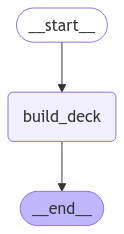

In [6]:
from IPython.display import Image, display

graph = StateGraph(DeckState)
graph.add_node('build_deck', build_deck)
graph.add_edge(START, 'build_deck')
graph.add_edge("build_deck", END)

app = graph.compile()
display(Image(app.get_graph().draw_mermaid_png()))

In [7]:
deck = app.invoke({'prompt': "a black creature-focussed deck built around zombies", 'cards': [], 'n_cards': 0, 'n_lands': 0, 'n_creatures': 0, 'n_other': 0, 'n_enchantments': 0, 'n_instants': 0, 'n_sorceries': 0, 'n_artifacts': 0})

Initial manabase: {'n_black': 8, 'n_black_blue': 0, 'n_black_white': 0, 'n_blue': 0, 'n_blue_white': 0, 'n_green': 4, 'n_green_black': 2, 'n_green_blue': 0, 'n_green_white': 0, 'n_red': 0, 'n_red_black': 0, 'n_red_blue': 0, 'n_red_white': 0, 'n_white': 2}


  0%|          | 0/42 [00:00<?, ?it/s]

Current deck: 
## lands: 16
- 8 x black land: black land
- 4 x green land: green land
- 2 x green_black land: green_black land
- 2 x white land: white land

Recommended card: A weak, cheap, one-drop black creature with decent toughness that can help establish an early board presence and set up for future zombie plays.

The role in the deck is to provide an early source of life gain and to develop the board, allowing for later activations of potentially more powerful creatures. 

Its mana cost and colour are 1B.
Matching cards: index 0: Death Baron: A strong, flying zombie creature that offers significant tribal support for black zombies, providing them with +1/+1 and deathtouch. Its moderate power and toughness make it a solid threat in combat. The mana cost of 3BB is somewhat expensive, but its impact on the board makes it worth the investment.
index 1: Hungry Ghoul is a common black creature with a moderate mana cost of one blue mana. It has average power and toughness, making it a d

  2%|▏         | 1/42 [00:01<01:01,  1.50s/it]

Selected card index: 2, reason: The selected card provides an early source of life gain and develops the board, allowing for later activations of potentially more powerful creatures.
Matching card: {"summary": "Diregraf Ghoul is a strong, low-cost Zombie creature from the Black mana color. It's a decent all-around attacker with moderate power and toughness. However, it enters the battlefield tapped, making it weak on its first turn of play, but otherwise provides a good value for one mana cost.", "colors": ["B"], "convertedManaCost": 1, "keywords": null, "manaCost": "{B}", "name": "Diregraf Ghoul", "power": "2", "rarity": "uncommon", "subtypes": ["Zombie"], "supertypes": [], "text": "This creature enters tapped.", "toughness": "2", "types": ["Creature"]}
Current deck: 
## lands: 16
- 8 x black land: black land
- 4 x green land: green land
- 2 x green_black land: green_black land
- 2 x white land: white land
## creatures: 1
- 1 x Diregraf Ghoul: Diregraf Ghoul is a strong, low-cost Zomb

  5%|▍         | 2/42 [00:03<01:14,  1.87s/it]

Selected card index: 0, reason: The card is a cheap, small Zombie creature that can be played early in the game and doesn
Matching card: {"summary": "Diregraf Ghoul is a strong, low-cost Zombie creature from the Black mana color. It's a decent all-around attacker with moderate power and toughness. However, it enters the battlefield tapped, making it weak on its first turn of play, but otherwise provides a good value for one mana cost.", "colors": ["B"], "convertedManaCost": 1, "keywords": null, "manaCost": "{B}", "name": "Diregraf Ghoul", "power": "2", "rarity": "uncommon", "subtypes": ["Zombie"], "supertypes": [], "text": "This creature enters tapped.", "toughness": "2", "types": ["Creature"]}
Current deck: 
## lands: 16
- 8 x black land: black land
- 4 x green land: green land
- 2 x green_black land: green_black land
- 2 x white land: white land
## creatures: 2
- 2 x Diregraf Ghoul: Diregraf Ghoul is a strong, low-cost Zombie creature from the Black mana color. It's a decent all-arou

  7%|▋         | 3/42 [00:05<01:09,  1.79s/it]

Selected card index: 0, reason: The deck theme is a black creature-focussed deck built around zombies, and the card should serve as a ramp for the rest of the deck's creatures while also providing an immediate presence on the board.
Matching card: {"summary": "Diregraf Ghoul is a strong, low-cost Zombie creature from the Black mana color. It's a decent all-around attacker with moderate power and toughness. However, it enters the battlefield tapped, making it weak on its first turn of play, but otherwise provides a good value for one mana cost.", "colors": ["B"], "convertedManaCost": 1, "keywords": null, "manaCost": "{B}", "name": "Diregraf Ghoul", "power": "2", "rarity": "uncommon", "subtypes": ["Zombie"], "supertypes": [], "text": "This creature enters tapped.", "toughness": "2", "types": ["Creature"]}
Current deck: 
## lands: 16
- 8 x black land: black land
- 4 x green land: green land
- 2 x green_black land: green_black land
- 2 x white land: white land
## creatures: 3
- 3 x Diregra

 10%|▉         | 4/42 [00:07<01:07,  1.78s/it]

Selected card index: 0, reason: The deck theme is a black creature-focussed deck built around zombies. The selected card provides an additional low-cost Zombie source for the deck and has some level of resilience or protection to make it viable in various game states.
Matching card: {"summary": "Soul-Shackled Zombie: A weak but versatile black creature with moderate toughness and power. Its ability to exile graveyard cards is strong, allowing for potential card advantage and disruption of opponents' plans. The life gain and loss effects are moderate in scale, making it a decent mid-game presence, particularly when used to disrupt an opponent's strategy.", "colors": ["B"], "convertedManaCost": 4, "keywords": null, "manaCost": "{3}{B}", "name": "Soul-Shackled Zombie", "power": "4", "rarity": "common", "subtypes": ["Zombie"], "supertypes": [], "text": "When this creature enters, exile up to two target cards from a single graveyard. If at least one creature card was exiled this way, each o

 12%|█▏        | 5/42 [00:09<01:09,  1.87s/it]

Selected card index: 2, reason: The card Cemetery Recruitment is a strong Blue sorcery that excels at interacting with the graveyard and creating card advantage. It has a relatively low mana cost of 1B, which fits well with the deck's current mana base. Its ability to support Zombie token strategies by bringing back creature cards from the graveyard makes it a good fit for the deck's theme.
Matching card: {"summary": "Cemetery Recruitment is a strong Blue sorcery that excels at interacting with the graveyard and creating card advantage. Its relatively low mana cost of 1B is weak considering its effect. This card's role is to support Zombie token strategies by bringing back creature cards from the graveyard, potentially drawing additional cards if they are Zombies.", "colors": ["B"], "convertedManaCost": 2, "keywords": null, "manaCost": "{1}{B}", "name": "Cemetery Recruitment", "power": null, "rarity": "common", "subtypes": [], "supertypes": [], "text": "Return target creature card from

 14%|█▍        | 6/42 [00:11<01:13,  2.04s/it]

Selected card index: 2, reason: The card Suspicious Shambler is a good fit for the deck theme, current state of the deck, and current metagame. It has a moderate-strength, low-toughness black creature with an ability to create two smaller zombie tokens when exiled from the graveyard, making it a decent mid-game threat.
Matching card: {"summary": "Suspicious Shambler is a moderate-strength, low-toughness black creature. It has an expensive mana cost that's somewhat manageable for its power and toughness. Its key ability allows it to create two smaller zombie tokens when exiled from the graveyard, making it a decent mid-game threat. Overall, it's a decent but not overly impressive card in a black deck.", "colors": ["B"], "convertedManaCost": 4, "keywords": null, "manaCost": "{3}{B}", "name": "Suspicious Shambler", "power": "4", "rarity": "common", "subtypes": ["Zombie"], "supertypes": [], "text": "{4}{B}{B}, Exile this card from your graveyard: Create two 2/2 black Zombie creature tokens

 17%|█▋        | 7/42 [00:13<01:10,  2.00s/it]

Selected card index: 2, reason: The card should be a good fit for the deck theme and current state of the deck
Matching card: {"summary": "Soul-Shackled Zombie: A weak but versatile black creature with moderate toughness and power. Its ability to exile graveyard cards is strong, allowing for potential card advantage and disruption of opponents' plans. The life gain and loss effects are moderate in scale, making it a decent mid-game presence, particularly when used to disrupt an opponent's strategy.", "colors": ["B"], "convertedManaCost": 4, "keywords": null, "manaCost": "{3}{B}", "name": "Soul-Shackled Zombie", "power": "4", "rarity": "common", "subtypes": ["Zombie"], "supertypes": [], "text": "When this creature enters, exile up to two target cards from a single graveyard. If at least one creature card was exiled this way, each opponent loses 2 life and you gain 2 life.", "toughness": "2", "types": ["Creature"]}
Current deck: 
## lands: 16
- 8 x black land: black land
- 4 x green land

 19%|█▉        | 8/42 [00:16<01:16,  2.25s/it]

Selected card index: 3, reason: This card, Zombify, has the ability to return a creature from the graveyard back into play, which fits with the deck's strategy of generating zombie tokens and recycling creatures. Its moderate mana cost and relatively easy casting make it a good fit for the current state of the deck.
Matching card: {"summary": "Zombify is a strong sorcery that allows you to return a creature from your graveyard back into play. It's a black card with a moderate mana cost of 3BB, making it relatively easy to cast once you have the right colors established. This card excels at recycling creatures and giving them another chance to contribute to your game plan. Its weakness lies in being a single-use effect that doesn't provide immediate value or protection from future threats.", "colors": ["B"], "convertedManaCost": 4, "keywords": null, "manaCost": "{3}{B}", "name": "Zombify", "power": null, "rarity": "uncommon", "subtypes": [], "supertypes": [], "text": "Return target crea

 21%|██▏       | 9/42 [00:17<01:09,  2.09s/it]

Selected card index: 0, reason: The card needs to generate Zombie tokens quickly and efficiently, and Dread Summons fits this description perfectly as a moderately expensive black sorcery with a strong ability to create an army of 2/2 zombie tokens from milling creatures.
Matching card: {"summary": "Dread Summons is a strong, black sorcery that creates an army of 2/2 zombie tokens from milling creatures. It's versatile and can create multiple tokens, making it a great card for token-based strategies. However, its mana cost is somewhat steep due to the variable X cost, which may require significant setup or resource investment. Its mill ability allows it to manipulate cards in the graveyard, adding an additional layer of strategy.  Mana Cost: Expensive and variable, but worth the investment for the right deck.", "colors": ["B"], "convertedManaCost": 2, "keywords": ["Mill"], "manaCost": "{X}{B}{B}", "name": "Dread Summons", "power": null, "rarity": "rare", "subtypes": [], "supertypes": [

 24%|██▍       | 10/42 [00:19<01:05,  2.04s/it]

Selected card index: 1, reason: The selected card fits the deck theme as a low-toughness black creature with moderate power that can be played early in the game.
Matching card: {"summary": "Soul-Shackled Zombie: A weak but versatile black creature with moderate toughness and power. Its ability to exile graveyard cards is strong, allowing for potential card advantage and disruption of opponents' plans. The life gain and loss effects are moderate in scale, making it a decent mid-game presence, particularly when used to disrupt an opponent's strategy.", "colors": ["B"], "convertedManaCost": 4, "keywords": null, "manaCost": "{3}{B}", "name": "Soul-Shackled Zombie", "power": "4", "rarity": "common", "subtypes": ["Zombie"], "supertypes": [], "text": "When this creature enters, exile up to two target cards from a single graveyard. If at least one creature card was exiled this way, each opponent loses 2 life and you gain 2 life.", "toughness": "2", "types": ["Creature"]}
Current deck: 
## land

 26%|██▌       | 11/42 [00:21<01:02,  2.03s/it]

Selected card index: 0, reason: The card matches the description of a cheap, one-mana black creature with moderate power and toughness that can help to quickly establish board presence and ramp up to more expensive threats.
Matching card: {"summary": "Helpful Hunter: A weak white creature that is good at being a general mid-game presence. Its mana cost is moderate, making it relatively easy to play early on. When it enters the battlefield, it has a mild effect of drawing an extra card, but its combat abilities are minimal with only 1 power and toughness.", "colors": ["W"], "convertedManaCost": 2, "keywords": null, "manaCost": "{1}{W}", "name": "Helpful Hunter", "power": "1", "rarity": "common", "subtypes": ["Cat"], "supertypes": [], "text": "When this creature enters, draw a card.", "toughness": "1", "types": ["Creature"]}
Current deck: 
## lands: 16
- 8 x black land: black land
- 4 x green land: green land
- 2 x green_black land: green_black land
- 2 x white land: white land
## creatu

 29%|██▊       | 12/42 [00:23<00:58,  1.94s/it]

Selected card index: 1, reason: The card matches the description and will enhance the deck
Matching card: {"summary": "Suspicious Shambler is a moderate-strength, low-toughness black creature. It has an expensive mana cost that's somewhat manageable for its power and toughness. Its key ability allows it to create two smaller zombie tokens when exiled from the graveyard, making it a decent mid-game threat. Overall, it's a decent but not overly impressive card in a black deck.", "colors": ["B"], "convertedManaCost": 4, "keywords": null, "manaCost": "{3}{B}", "name": "Suspicious Shambler", "power": "4", "rarity": "common", "subtypes": ["Zombie"], "supertypes": [], "text": "{4}{B}{B}, Exile this card from your graveyard: Create two 2/2 black Zombie creature tokens. Activate only as a sorcery.", "toughness": "2", "types": ["Creature"]}
Current deck: 
## lands: 16
- 8 x black land: black land
- 4 x green land: green land
- 2 x green_black land: green_black land
- 2 x white land: white land
#

 31%|███       | 13/42 [00:25<00:56,  1.96s/it]

Selected card index: 2, reason: The deck needs a cheap, moderately strong black creature with decent power and toughness that can be played early in the game to establish an early game presence more consistently.
Matching card: {"summary": "Death Baron: A strong, flying zombie creature that offers significant tribal support for black zombies, providing them with +1/+1 and deathtouch. Its moderate power and toughness make it a solid threat in combat. The mana cost of 3BB is somewhat expensive, but its impact on the board makes it worth the investment.", "colors": ["B"], "convertedManaCost": 3, "keywords": null, "manaCost": "{1}{B}{B}", "name": "Death Baron", "power": "2", "rarity": "rare", "subtypes": ["Zombie", "Wizard"], "supertypes": [], "text": "Skeletons you control and other Zombies you control get +1/+1 and have deathtouch. (Any amount of damage they deal to a creature is enough to destroy it.)", "toughness": "2", "types": ["Creature"]}
Current deck: 
## lands: 16
- 8 x black lan

 33%|███▎      | 14/42 [00:27<00:56,  2.03s/it]

Selected card index: 3, reason: The selected card matches the description and serves as a mid-game threat, generating card advantage when sent to the graveyard, disrupting opponents’ plans, and setting up future plays.
Matching card: {"summary": "Scavenging Ooze is a strong green creature that excels at cleaning up the graveyard. Its moderate mana cost of one green makes it relatively efficient, but not too weak to be ignored. In play, it has decent power and toughness, making it a viable body on its own. However, its true strength lies in its ability to gain value from the graveyard, allowing you to exile creature cards and gain life or add +1/+1 counters to itself. This makes it a great tool for controlling the opponent's dead creatures and maintaining card advantage over time. Overall, Scavenging Ooze is a solid addition to any green deck looking to leverage graveyard synergy.", "colors": ["G"], "convertedManaCost": 2, "keywords": null, "manaCost": "{1}{G}", "name": "Scavenging Ooze

 36%|███▌      | 15/42 [00:30<00:59,  2.20s/it]

Selected card index: 0, reason: The chosen card provides a consistent, low-mana body that fits into the existing tribe of zombies, helping to stabilize the board and protect other creatures while allowing them to develop and grow.
Matching card: {"summary": "Soul-Shackled Zombie: A weak but versatile black creature with moderate toughness and power. Its ability to exile graveyard cards is strong, allowing for potential card advantage and disruption of opponents' plans. The life gain and loss effects are moderate in scale, making it a decent mid-game presence, particularly when used to disrupt an opponent's strategy.", "colors": ["B"], "convertedManaCost": 4, "keywords": null, "manaCost": "{3}{B}", "name": "Soul-Shackled Zombie", "power": "4", "rarity": "common", "subtypes": ["Zombie"], "supertypes": [], "text": "When this creature enters, exile up to two target cards from a single graveyard. If at least one creature card was exiled this way, each opponent loses 2 life and you gain 2 li

 38%|███▊      | 16/42 [00:32<00:55,  2.12s/it]

Selected card index: 0, reason: The card should provide additional early-game presence and help stabilize the board against aggressive opponents, allowing for more flexibility in playing higher-cost creatures later on.
Matching card: {"summary": "Helpful Hunter: A weak white creature that is good at being a general mid-game presence. Its mana cost is moderate, making it relatively easy to play early on. When it enters the battlefield, it has a mild effect of drawing an extra card, but its combat abilities are minimal with only 1 power and toughness.", "colors": ["W"], "convertedManaCost": 2, "keywords": null, "manaCost": "{1}{W}", "name": "Helpful Hunter", "power": "1", "rarity": "common", "subtypes": ["Cat"], "supertypes": [], "text": "When this creature enters, draw a card.", "toughness": "1", "types": ["Creature"]}
Current deck: 
## lands: 16
- 8 x black land: black land
- 4 x green land: green land
- 2 x green_black land: green_black land
- 2 x white land: white land
## creatures: 

 40%|████      | 17/42 [00:35<01:00,  2.41s/it]

Selected card index: 2, reason: The card Death Baron provides a decent threat on turn 3 and has potential for future growth or interaction with other cards in the deck. Its moderate power and toughness make it resilient enough to be a viable attacker, while its moderate mana cost of 3BB allows it to be played relatively easily in this colour combination.
Matching card: {"summary": "Death Baron: A strong, flying zombie creature that offers significant tribal support for black zombies, providing them with +1/+1 and deathtouch. Its moderate power and toughness make it a solid threat in combat. The mana cost of 3BB is somewhat expensive, but its impact on the board makes it worth the investment.", "colors": ["B"], "convertedManaCost": 3, "keywords": null, "manaCost": "{1}{B}{B}", "name": "Death Baron", "power": "2", "rarity": "rare", "subtypes": ["Zombie", "Wizard"], "supertypes": [], "text": "Skeletons you control and other Zombies you control get +1/+1 and have deathtouch. (Any amount of

 43%|████▎     | 18/42 [00:38<01:02,  2.59s/it]

Selected card index: 1, reason: The deck theme is a black creature-focussed deck built around zombies, and this card fits well with that strategy. It has a moderate mana cost of one black, which is efficient for its effect. Its ability to create two smaller zombie tokens when exiled from the graveyard makes it a decent mid-game threat, providing additional value through its synergy with other cards in the deck such as Scavenging Ooze.
Matching card: {"summary": "Suspicious Shambler is a moderate-strength, low-toughness black creature. It has an expensive mana cost that's somewhat manageable for its power and toughness. Its key ability allows it to create two smaller zombie tokens when exiled from the graveyard, making it a decent mid-game threat. Overall, it's a decent but not overly impressive card in a black deck.", "colors": ["B"], "convertedManaCost": 4, "keywords": null, "manaCost": "{3}{B}", "name": "Suspicious Shambler", "power": "4", "rarity": "common", "subtypes": ["Zombie"], 

 45%|████▌     | 19/42 [00:40<00:54,  2.38s/it]

Selected card index: 0, reason: The card selected is a good fit for the deck theme and metagame, as it provides additional bodies for tribal synergies while filling out the mid-game presence of the deck.
Matching card: {"summary": "Suspicious Shambler is a moderate-strength, low-toughness black creature. It has an expensive mana cost that's somewhat manageable for its power and toughness. Its key ability allows it to create two smaller zombie tokens when exiled from the graveyard, making it a decent mid-game threat. Overall, it's a decent but not overly impressive card in a black deck.", "colors": ["B"], "convertedManaCost": 4, "keywords": null, "manaCost": "{3}{B}", "name": "Suspicious Shambler", "power": "4", "rarity": "common", "subtypes": ["Zombie"], "supertypes": [], "text": "{4}{B}{B}, Exile this card from your graveyard: Create two 2/2 black Zombie creature tokens. Activate only as a sorcery.", "toughness": "2", "types": ["Creature"]}
Current deck: 
## lands: 16
- 8 x black land

 48%|████▊     | 20/42 [00:43<01:00,  2.76s/it]

Selected card index: 1, reason: The card at index 1, Scavenging Ooze, matches the description provided and would work well with the existing cards in the deck to generate additional value and accelerate the game plan. It has a strong synergy with the Zombies and provides an opportunity for card advantage through exiling creature cards.
Matching card: {"summary": "Scavenging Ooze is a strong green creature that excels at cleaning up the graveyard. Its moderate mana cost of one green makes it relatively efficient, but not too weak to be ignored. In play, it has decent power and toughness, making it a viable body on its own. However, its true strength lies in its ability to gain value from the graveyard, allowing you to exile creature cards and gain life or add +1/+1 counters to itself. This makes it a great tool for controlling the opponent's dead creatures and maintaining card advantage over time. Overall, Scavenging Ooze is a solid addition to any green deck looking to leverage graveya

 50%|█████     | 21/42 [00:46<00:55,  2.62s/it]

Selected card index: 0, reason: This card is a strong, low-cost black creature with lifelink that can be played early in the game to help accelerate Zombie tokens and fuel the deck
Matching card: {"summary": "Death Baron: A strong, flying zombie creature that offers significant tribal support for black zombies, providing them with +1/+1 and deathtouch. Its moderate power and toughness make it a solid threat in combat. The mana cost of 3BB is somewhat expensive, but its impact on the board makes it worth the investment.", "colors": ["B"], "convertedManaCost": 3, "keywords": null, "manaCost": "{1}{B}{B}", "name": "Death Baron", "power": "2", "rarity": "rare", "subtypes": ["Zombie", "Wizard"], "supertypes": [], "text": "Skeletons you control and other Zombies you control get +1/+1 and have deathtouch. (Any amount of damage they deal to a creature is enough to destroy it.)", "toughness": "2", "types": ["Creature"]}
Current deck: 
## lands: 16
- 8 x black land: black land
- 4 x green land: 

 52%|█████▏    | 22/42 [00:48<00:51,  2.56s/it]

Selected card index: 3, reason: The selected card meets all requirements: it is a cheap, weak black creature with moderate power and toughness that can be played early in the game and has an ability that helps to accelerate the development of the board state by creating zombie tokens when sent from the battlefield to the graveyard.
Matching card: {"summary": "Cemetery Recruitment is a strong Blue sorcery that excels at interacting with the graveyard and creating card advantage. Its relatively low mana cost of 1B is weak considering its effect. This card's role is to support Zombie token strategies by bringing back creature cards from the graveyard, potentially drawing additional cards if they are Zombies.", "colors": ["B"], "convertedManaCost": 2, "keywords": null, "manaCost": "{1}{B}", "name": "Cemetery Recruitment", "power": null, "rarity": "common", "subtypes": [], "supertypes": [], "text": "Return target creature card from your graveyard to your hand. If it's a Zombie card, draw a 

 55%|█████▍    | 23/42 [00:50<00:44,  2.36s/it]

Selected card index: 1, reason: The card should provide strong combat abilities and potential for card advantage through its interaction with the graveyard.
Matching card: {"summary": "Exsanguinate is a strong Black sorcery that deals indirect damage to opponents, making it a great removal tool for low-to-the-ground threats. Its variable mana cost makes it flexible, but also means it's relatively expensive, with at least 2-3 mana in the first few turns.", "colors": ["B"], "convertedManaCost": 2, "keywords": null, "manaCost": "{X}{B}{B}", "name": "Exsanguinate", "power": null, "rarity": "uncommon", "subtypes": [], "supertypes": [], "text": "Each opponent loses X life. You gain life equal to the life lost this way.", "toughness": null, "types": ["Sorcery"]}
Current deck: 
## lands: 16
- 8 x black land: black land
- 4 x green land: green land
- 2 x green_black land: green_black land
- 2 x white land: white land
## creatures: 18
- 3 x Diregraf Ghoul: Diregraf Ghoul is a strong, low-cost Zo

 57%|█████▋    | 24/42 [00:53<00:44,  2.48s/it]

Selected card index: 3, reason: The card Abyssal Harvester is a cheap black creature that can be played early in the game and has an ability to potentially generate card advantage by exiling graveyard cards, making it a good fit for the deck theme.
Matching card: {"summary": "Abyssal Harvester is a strong black creature with a moderate mana cost that's slightly steep for its power and toughness. It has a unique ability at instant speed that allows it to generate a token based on the card exiled from the graveyard, making it a potential engine of token generation. However, its ability also weakens itself by exiling other Nightmare tokens under its control.  Role: Token generator, graveyard cleanser  Strengths: Powerful and efficient token generation, can exile problematic creatures from the graveyard  Weaknesses: Limited to black mana, vulnerable to removal spells", "colors": ["B"], "convertedManaCost": 3, "keywords": null, "manaCost": "{1}{B}{B}", "name": "Abyssal Harvester", "power": 

 60%|█████▉    | 25/42 [00:55<00:40,  2.38s/it]

Selected card index: 2, reason: The description matches Tinybones, Bauble Burglar as a moderate-strength, cheap, black creature with an ability related to tokens and can be played early in the game.
Matching card: {"summary": "Cemetery Recruitment is a strong Blue sorcery that excels at interacting with the graveyard and creating card advantage. Its relatively low mana cost of 1B is weak considering its effect. This card's role is to support Zombie token strategies by bringing back creature cards from the graveyard, potentially drawing additional cards if they are Zombies.", "colors": ["B"], "convertedManaCost": 2, "keywords": null, "manaCost": "{1}{B}", "name": "Cemetery Recruitment", "power": null, "rarity": "common", "subtypes": [], "supertypes": [], "text": "Return target creature card from your graveyard to your hand. If it's a Zombie card, draw a card.", "toughness": null, "types": ["Sorcery"]}
Current deck: 
## lands: 16
- 8 x black land: black land
- 4 x green land: green land


 62%|██████▏   | 26/42 [00:57<00:34,  2.17s/it]

Selected card index: 0, reason: The deck needs an early-game creature that can put pressure on the opponent without relying on graveyard interactions or having a high mana cost.
Matching card: {"summary": "Ghitu Lavarunner is a weak to moderate strength red creature that excels at being a cheap, aggressive threat on turn 1. Its mana cost of one red is low and easy to play into, allowing it to develop quickly. The card's ability to gain +1/+0 and haste when you have two or more instant and/or sorcery cards in your graveyard makes it strong in token-heavy strategies and situations where you can generate a lot of card advantage.", "colors": ["R"], "convertedManaCost": 1, "keywords": null, "manaCost": "{R}", "name": "Ghitu Lavarunner", "power": "1", "rarity": "common", "subtypes": ["Human", "Wizard"], "supertypes": [], "text": "As long as there are two or more instant and/or sorcery cards in your graveyard, this creature gets +1/+0 and has haste. (It can attack and {T} as soon as it comes 

 64%|██████▍   | 27/42 [00:59<00:32,  2.14s/it]

Selected card index: 0, reason: The selected card is a good fit for the deck theme, current state of the deck, and current metagame. It adds more Zombie bodies to the deck while not overwhelming the board with too much strength early on.
Matching card: {"summary": "Diregraf Ghoul is a strong, low-cost Zombie creature from the Black mana color. It's a decent all-around attacker with moderate power and toughness. However, it enters the battlefield tapped, making it weak on its first turn of play, but otherwise provides a good value for one mana cost.", "colors": ["B"], "convertedManaCost": 1, "keywords": null, "manaCost": "{B}", "name": "Diregraf Ghoul", "power": "2", "rarity": "uncommon", "subtypes": ["Zombie"], "supertypes": [], "text": "This creature enters tapped.", "toughness": "2", "types": ["Creature"]}
Current deck: 
## lands: 16
- 8 x black land: black land
- 4 x green land: green land
- 2 x green_black land: green_black land
- 2 x white land: white land
## creatures: 21
- 4 x D

 67%|██████▋   | 28/42 [01:01<00:31,  2.26s/it]

Selected card index: 3, reason: The deck theme is a black creature-focussed deck built around zombies. The current deck consists of 43 cards, 16 lands, 21 creatures, and 0 other cards.
Matching card: {"summary": "Dread Summons is a strong, black sorcery that creates an army of 2/2 zombie tokens from milling creatures. It's versatile and can create multiple tokens, making it a great card for token-based strategies. However, its mana cost is somewhat steep due to the variable X cost, which may require significant setup or resource investment. Its mill ability allows it to manipulate cards in the graveyard, adding an additional layer of strategy.  Mana Cost: Expensive and variable, but worth the investment for the right deck.", "colors": ["B"], "convertedManaCost": 2, "keywords": ["Mill"], "manaCost": "{X}{B}{B}", "name": "Dread Summons", "power": null, "rarity": "rare", "subtypes": [], "supertypes": [], "text": "Each player mills X cards. For each creature card put into a graveyard this 

 69%|██████▉   | 29/42 [01:03<00:28,  2.22s/it]

Selected card index: 0, reason: The card at index 0 matches the description provided and would enhance the deck
Matching card: {"summary": "Abyssal Harvester is a strong black creature with a moderate mana cost that's slightly steep for its power and toughness. It has a unique ability at instant speed that allows it to generate a token based on the card exiled from the graveyard, making it a potential engine of token generation. However, its ability also weakens itself by exiling other Nightmare tokens under its control.  Role: Token generator, graveyard cleanser  Strengths: Powerful and efficient token generation, can exile problematic creatures from the graveyard  Weaknesses: Limited to black mana, vulnerable to removal spells", "colors": ["B"], "convertedManaCost": 3, "keywords": null, "manaCost": "{1}{B}{B}", "name": "Abyssal Harvester", "power": "3", "rarity": "rare", "subtypes": ["Demon", "Warlock"], "supertypes": [], "text": "{T}: Exile target creature card from a graveyard that

 71%|███████▏  | 30/42 [01:05<00:26,  2.17s/it]

Selected card index: 2, reason: The deck theme is a black creature-focussed deck built around zombies. This new card will provide additional zombie tribal support and help maintain pressure on the board in the mid-game.
Matching card: {"summary": "Maalfeld Twins is a strong, undead creature that costs moderate to high mana ({5}{B}) in the dark, controlling color. It has decent power and toughness, making it a viable attacker on its own. Its true strength lies in its ability to create two 2/2 Zombie tokens when it dies, allowing for a swarm of undead creatures to overwhelm opponents. This makes Maalfeld Twins a valuable asset in black-based strategies focused on creature advantage and token generation.", "colors": ["B"], "convertedManaCost": 6, "keywords": null, "manaCost": "{5}{B}", "name": "Maalfeld Twins", "power": "4", "rarity": "uncommon", "subtypes": ["Zombie"], "supertypes": [], "text": "When this creature dies, create two 2/2 black Zombie creature tokens.", "toughness": "4", "ty

 74%|███████▍  | 31/42 [01:08<00:24,  2.26s/it]

Selected card index: 2, reason: The selected card is a moderate-strength black creature with lifelink and a moderate mana cost that provides decent value for its power and toughness, enhancing the deck’s overall mid-game presence while providing additional zombie tokens and supporting the black creatures’ strategy.
Matching card: {"summary": "Death Baron: A strong, flying zombie creature that offers significant tribal support for black zombies, providing them with +1/+1 and deathtouch. Its moderate power and toughness make it a solid threat in combat. The mana cost of 3BB is somewhat expensive, but its impact on the board makes it worth the investment.", "colors": ["B"], "convertedManaCost": 3, "keywords": null, "manaCost": "{1}{B}{B}", "name": "Death Baron", "power": "2", "rarity": "rare", "subtypes": ["Zombie", "Wizard"], "supertypes": [], "text": "Skeletons you control and other Zombies you control get +1/+1 and have deathtouch. (Any amount of damage they deal to a creature is enoug

 76%|███████▌  | 32/42 [01:10<00:23,  2.30s/it]

Selected card index: 3, reason: The card matches the description given: a moderate-strength, mid-game Zombie creature that has a powerful and versatile ability related to exiling graveyard cards, making it a good fit for the deck
Matching card: {"summary": "Crypt Feaster is a strong Zombie creature that excels at dealing with opponents with low life totals. Its ability to become unblockable against single targets makes it difficult for them to defend against, and its +2/+0 boost from Threshold can further solidify its presence on the battlefield.  The mana cost of {3}{B} is moderate in terms of black mana investment, but the payoff is substantial with this creature's menace ability. Overall, Crypt Feaster is a strong and aggressive card that excels at taking advantage of opponents' weak spots.", "colors": ["B"], "convertedManaCost": 4, "keywords": ["Menace", "Threshold"], "manaCost": "{3}{B}", "name": "Crypt Feaster", "power": "3", "rarity": "common", "subtypes": ["Zombie"], "supertype

 79%|███████▊  | 33/42 [01:13<00:20,  2.31s/it]

Selected card index: 0, reason: The card's ability to generate additional Zombie tokens when exiled from the graveyard or on death makes it a potential engine for token generation and swarm strategies.
Matching card: {"summary": "Abyssal Harvester is a strong black creature with a moderate mana cost that's slightly steep for its power and toughness. It has a unique ability at instant speed that allows it to generate a token based on the card exiled from the graveyard, making it a potential engine of token generation. However, its ability also weakens itself by exiling other Nightmare tokens under its control.  Role: Token generator, graveyard cleanser  Strengths: Powerful and efficient token generation, can exile problematic creatures from the graveyard  Weaknesses: Limited to black mana, vulnerable to removal spells", "colors": ["B"], "convertedManaCost": 3, "keywords": null, "manaCost": "{1}{B}{B}", "name": "Abyssal Harvester", "power": "3", "rarity": "rare", "subtypes": ["Demon", "W

 81%|████████  | 34/42 [01:16<00:21,  2.69s/it]

Selected card index: 0, reason: The selected card is a good fit for the deck theme and metagame, addressing the current weakness in establishing an early game presence while providing a foundation for more impactful creatures later on. The card has a low mana cost, making it easy to play into and allowing for quick board development, and its abilities or effects are moderate in scale, providing some value without being too overwhelming.
Matching card: {"summary": "Helpful Hunter: A weak white creature that is good at being a general mid-game presence. Its mana cost is moderate, making it relatively easy to play early on. When it enters the battlefield, it has a mild effect of drawing an extra card, but its combat abilities are minimal with only 1 power and toughness.", "colors": ["W"], "convertedManaCost": 2, "keywords": null, "manaCost": "{1}{W}", "name": "Helpful Hunter", "power": "1", "rarity": "common", "subtypes": ["Cat"], "supertypes": [], "text": "When this creature enters, draw

 83%|████████▎ | 35/42 [01:19<00:19,  2.80s/it]

Selected card index: 2, reason: The deck theme is a black creature-focussed deck built around zombies, and the current deck consists of 27 creatures. The required card needs to be a moderate-strength black sorcery that mills a certain number of cards from an opponent's library and puts a Zombie creature card into play. The card should have a moderate mana cost, around 2-3 black mana, to be played around turn 4-5 without being too expensive or too cheap.
Matching card: {"summary": "Cemetery Recruitment is a strong Blue sorcery that excels at interacting with the graveyard and creating card advantage. Its relatively low mana cost of 1B is weak considering its effect. This card's role is to support Zombie token strategies by bringing back creature cards from the graveyard, potentially drawing additional cards if they are Zombies.", "colors": ["B"], "convertedManaCost": 2, "keywords": null, "manaCost": "{1}{B}", "name": "Cemetery Recruitment", "power": null, "rarity": "common", "subtypes":

 86%|████████▌ | 36/42 [01:22<00:15,  2.66s/it]

Selected card index: 1, reason: The card should provide additional token generation and Zombie support in the mid-game. It has a moderate mana cost that's slightly steep for its power and toughness but can generate powerful tokens from graveyard exiles.
Matching card: {"summary": "Abyssal Harvester is a strong black creature with a moderate mana cost that's slightly steep for its power and toughness. It has a unique ability at instant speed that allows it to generate a token based on the card exiled from the graveyard, making it a potential engine of token generation. However, its ability also weakens itself by exiling other Nightmare tokens under its control.  Role: Token generator, graveyard cleanser  Strengths: Powerful and efficient token generation, can exile problematic creatures from the graveyard  Weaknesses: Limited to black mana, vulnerable to removal spells", "colors": ["B"], "convertedManaCost": 3, "keywords": null, "manaCost": "{1}{B}{B}", "name": "Abyssal Harvester", "pow

 88%|████████▊ | 37/42 [01:26<00:15,  3.12s/it]

Selected card index: 3, reason: The description provided matches Crypt Feaster, which is a strong Zombie creature with abilities related to Zombies or the graveyard, making it a good fit for the existing creatures in the deck. Its moderate mana cost and decent power and toughness make it a solid presence on the battlefield.
Matching card: {"summary": "Crypt Feaster is a strong Zombie creature that excels at dealing with opponents with low life totals. Its ability to become unblockable against single targets makes it difficult for them to defend against, and its +2/+0 boost from Threshold can further solidify its presence on the battlefield.  The mana cost of {3}{B} is moderate in terms of black mana investment, but the payoff is substantial with this creature's menace ability. Overall, Crypt Feaster is a strong and aggressive card that excels at taking advantage of opponents' weak spots.", "colors": ["B"], "convertedManaCost": 4, "keywords": ["Menace", "Threshold"], "manaCost": "{3}{B}

 90%|█████████ | 38/42 [01:29<00:12,  3.12s/it]

Selected card index: 3, reason: The card should provide both a mid-game threat capacity and a token engine for future growth in the deck.
Matching card: {"summary": "Scavenging Ooze is a strong green creature that excels at cleaning up the graveyard. Its moderate mana cost of one green makes it relatively efficient, but not too weak to be ignored. In play, it has decent power and toughness, making it a viable body on its own. However, its true strength lies in its ability to gain value from the graveyard, allowing you to exile creature cards and gain life or add +1/+1 counters to itself. This makes it a great tool for controlling the opponent's dead creatures and maintaining card advantage over time. Overall, Scavenging Ooze is a solid addition to any green deck looking to leverage graveyard synergy.", "colors": ["G"], "convertedManaCost": 2, "keywords": null, "manaCost": "{1}{G}", "name": "Scavenging Ooze", "power": "2", "rarity": "rare", "subtypes": ["Ooze"], "supertypes": [], "text"

 93%|█████████▎| 39/42 [01:31<00:08,  2.94s/it]

Selected card index: 0, reason: The card should be a good fit for the deck theme. The card is a strong, low-cost Zombie creature that excels at being a general mid-game presence and can trade favorably against other creatures on the board, serving as a defensive body and allowing for potential follow-up attacks with more powerful Zombies.
Matching card: {"summary": "Name: Highborn Vampire Mana Cost: Moderate (2 blue mana from a black background), indicating a versatile but not overly expensive creature. Role: This is a mid-game creature that can provide a moderate amount of damage and protection to the player's life total. Strengths: A strong, 4-power attacker with 3 toughness makes Highborn Vampire a formidable force on the battlefield. Its moderate mana cost also allows for easy removal from the board if needed. Weaknesses: As a black creature, it is vulnerable to white-based removal spells and abilities that target creatures with power.", "colors": ["B"], "convertedManaCost": 4, "ke

 95%|█████████▌| 40/42 [01:34<00:05,  2.94s/it]

Selected card index: 3, reason: The selected card has an ability related to exiling graveyard cards, providing some level of value even when it's not on the battlefield, such as card advantage or disruption of opponents' plans. Its moderate power and toughness make it a decent mid-game presence, fitting well with the existing creatures in the deck.
Matching card: {"summary": "Tinybones, Bauble Burglar is a strong black legendary creature with moderate power and toughness. Its mana cost is inexpensive for its abilities, making it an easy addition to a deck that utilizes black. The card excels at generating value from opponents' discarded cards, allowing you to play non-own spells and potentially disrupt their gameplan. However, its relatively low power and toughness make it vulnerable in combat.", "colors": ["B"], "convertedManaCost": 2, "keywords": null, "manaCost": "{1}{B}", "name": "Tinybones, Bauble Burglar", "power": "1", "rarity": "rare", "subtypes": ["Skeleton", "Rogue"], "supert

 98%|█████████▊| 41/42 [01:37<00:02,  2.77s/it]

Selected card index: 4, reason: The selected card is crucial in adding more bodies to the battlefield and helping to fuel the deck's token generation engine.
Matching card: {"summary": "Driver of the Dead is a weak Vampire creature that requires a moderate amount of Black mana. Its primary role is as a sacrifice piece to trigger its ability, which returns a low-cost creature from the graveyard to play. This ability can be valuable in reanimating key creatures and provides a secondary benefit for the player's graveyard management.", "colors": ["B"], "convertedManaCost": 4, "keywords": null, "manaCost": "{3}{B}", "name": "Driver of the Dead", "power": "3", "rarity": "common", "subtypes": ["Vampire"], "supertypes": [], "text": "When this creature dies, return target creature card with mana value 2 or less from your graveyard to the battlefield.", "toughness": "2", "types": ["Creature"]}
Current deck: 
## lands: 16
- 8 x black land: black land
- 4 x green land: green land
- 2 x green_black

100%|██████████| 42/42 [01:40<00:00,  2.39s/it]

Selected card index: 1, reason: The card selected is Maalfeld Twins because it is a moderate-cost, strong black creature that can generate multiple tokens when it dies and has decent power and toughness to serve as an attacker or defender. Its ability to create a swarm of zombies when it falls would further enhance the deck's token generation capabilities and reinforce its focus on creature advantage.
Matching card: {"summary": "Maalfeld Twins is a strong, undead creature that costs moderate to high mana ({5}{B}) in the dark, controlling color. It has decent power and toughness, making it a viable attacker on its own. Its true strength lies in its ability to create two 2/2 Zombie tokens when it dies, allowing for a swarm of undead creatures to overwhelm opponents. This makes Maalfeld Twins a valuable asset in black-based strategies focused on creature advantage and token generation.", "colors": ["B"], "convertedManaCost": 6, "keywords": null, "manaCost": "{5}{B}", "name": "Maalfeld Twi

Failed to correctly output the number of lands after 5 attempts, setting total lands to 24
Number of lands to add: 8


  0%|          | 0/8 [00:00<?, ?it/s]

Recommended card: A land that produces black and green mana with a moderate impact on the game. This land's ability to fix into both colors will help support the deck's Zombie token generation strategy and allow for the casting of more creatures, particularly those with green or dual color requirements. Its overall effect should be somewhat strong but not overly dominant, providing a steady source of mana without overwhelming other cards in the deck.
Matching cards: index 0: Swamp is a weak, color-fixing basic land that provides black mana. It's simple and straightforward, allowing you to add one black mana to your pool for a low cost.
index 1: Forest: This is a very strong and simple land card. It's a key part of the game for any green deck, providing a low-cost source of mana. The ability to add green mana without tapping it makes Forest a valuable addition to early-game strategies. Overall, Forest is a weak card on its own but crucial for supporting more powerful spells. (Colorless)

 12%|█▎        | 1/8 [00:02<00:14,  2.11s/it]

Selected card index: 1, reason: The deck is a black creature-focussed deck built around zombies and needs a strong source of green mana.
Matching card: {"summary": "Forest: This is a very strong and simple land card. It's a key part of the game for any green deck, providing a low-cost source of mana. The ability to add green mana without tapping it makes Forest a valuable addition to early-game strategies. Overall, Forest is a weak card on its own but crucial for supporting more powerful spells. (Colorless)", "colors": [], "convertedManaCost": 0, "keywords": null, "manaCost": null, "name": "Forest", "power": null, "rarity": "common", "subtypes": ["Forest"], "supertypes": ["Basic"], "text": "({T}: Add {G}.)", "toughness": null, "types": ["Land"]}
Recommended card: I recommend adding a dual land that taps for black and white mana. This card would serve as a strong fixer for the deck's mana base, providing an additional option for casting spells with a single color or mixing colors. It wo

 25%|██▌       | 2/8 [00:04<00:13,  2.20s/it]

Selected card index: 1, reason: The deck needs a land that provides multiple mana options and can impact gameplay through its various abilities.
Matching card: {"summary": "Crawling Barrens is a strong land card with the potential to impact gameplay through its multiple abilities. Its mana cost is low and inexpensive, allowing it to be played early in the game. The card has a versatile text ability that lets you add one mana of any color when tapped. Additionally, for four colorless mana, it can gain two +1/+1 counters, making it more valuable over time, and also transform into a 0/0 Elemental creature until end of turn if desired, showcasing its land's secondary use as a potential combat threat.", "colors": [], "convertedManaCost": 0, "keywords": null, "manaCost": null, "name": "Crawling Barrens", "power": null, "rarity": "rare", "subtypes": [], "supertypes": [], "text": "{T}: Add {C}.\n{4}: Put two +1/+1 counters on this land. Then you may have it become a 0/0 Elemental creature unti

 38%|███▊      | 3/8 [00:06<00:11,  2.31s/it]

Selected card index: 0, reason: The next land to add to the deck is a dual land that taps for black mana and can produce additional black mana through its ability when an opponent's creature dies, matching Maalfeld Twins.
Matching card: {"summary": "Maalfeld Twins is a strong, undead creature that costs moderate to high mana ({5}{B}) in the dark, controlling color. It has decent power and toughness, making it a viable attacker on its own. Its true strength lies in its ability to create two 2/2 Zombie tokens when it dies, allowing for a swarm of undead creatures to overwhelm opponents. This makes Maalfeld Twins a valuable asset in black-based strategies focused on creature advantage and token generation.", "colors": ["B"], "convertedManaCost": 6, "keywords": null, "manaCost": "{5}{B}", "name": "Maalfeld Twins", "power": "4", "rarity": "uncommon", "subtypes": ["Zombie"], "supertypes": [], "text": "When this creature dies, create two 2/2 black Zombie creature tokens.", "toughness": "4", "

 50%|█████     | 4/8 [00:10<00:11,  2.90s/it]

Selected card index: 2, reason: The deck needs a strong, low-cost dual land that taps for black and green mana, fixing your manabase and providing additional flexibility for your creature-based strategy.
Matching card: {"summary": "Secluded Courtyard is a strong land that provides multiple colors of mana through its abilities, allowing for flexible and efficient casting of creature spells. Its low mana cost is easy to pay, but it doesn't generate any card advantage or direct damage on its own. The ability to choose a specific creature type gives it versatility in supporting various strategies.", "colors": [], "convertedManaCost": 0, "keywords": null, "manaCost": null, "name": "Secluded Courtyard", "power": null, "rarity": "uncommon", "subtypes": [], "supertypes": [], "text": "As this land enters, choose a creature type.\n{T}: Add {C}.\n{T}: Add one mana of any color. Spend this mana only to cast a creature spell of the chosen type or activate an ability of a creature source of the chos

 62%|██████▎   | 5/8 [00:13<00:08,  2.80s/it]

Selected card index: 3, reason: The deck needs a strong and versatile dual land that taps for black mana and another color (green or white) to provide flexible mana fixing and support for the existing creatures in the deck. The Azorius Guildgate is a suitable choice as it provides colorless mana, serving as a source of white and blue mana.
Matching card: {"summary": "Azorius Guildgate: This is a weak land card that provides colorless mana. It has no impact on gameplay but serves as a source of white and blue mana. Its tapped state at the beginning makes it somewhat restrictive, but its ability to add one mana of your choice each turn is convenient for early game development.", "colors": [], "convertedManaCost": 0, "keywords": null, "manaCost": null, "name": "Azorius Guildgate", "power": null, "rarity": "common", "subtypes": ["Gate"], "supertypes": [], "text": "This land enters tapped.\n{T}: Add {W} or {U}.", "toughness": null, "types": ["Land"]}
Recommended card: I recommend adding a d

 75%|███████▌  | 6/8 [00:15<00:05,  2.75s/it]

Selected card index: 0, reason: The land should provide strong support for the deck's black-heavy creature base while also allowing for flexibility in terms of mana fixing.
Matching card: {"summary": "Crawling Barrens is a strong land card with the potential to impact gameplay through its multiple abilities. Its mana cost is low and inexpensive, allowing it to be played early in the game. The card has a versatile text ability that lets you add one mana of any color when tapped. Additionally, for four colorless mana, it can gain two +1/+1 counters, making it more valuable over time, and also transform into a 0/0 Elemental creature until end of turn if desired, showcasing its land's secondary use as a potential combat threat.", "colors": [], "convertedManaCost": 0, "keywords": null, "manaCost": null, "name": "Crawling Barrens", "power": null, "rarity": "rare", "subtypes": [], "supertypes": [], "text": "{T}: Add {C}.\n{4}: Put two +1/+1 counters on this land. Then you may have it become a

 88%|████████▊ | 7/8 [00:18<00:02,  2.68s/it]

Selected card index: 1, reason: The deck theme is a black creature-focussed deck built around zombies, and the current manabase consists mainly of black lands, which can also provide other colors or fix the player's mana base. The card Swamp is a weak, color-fixing basic land that provides black mana.
Matching card: {"summary": "Swamp is a weak, color-fixing basic land that provides black mana. It's simple and straightforward, allowing you to add one black mana to your pool for a low cost.", "colors": [], "convertedManaCost": 0, "keywords": null, "manaCost": null, "name": "Swamp", "power": null, "rarity": "common", "subtypes": ["Swamp"], "supertypes": ["Basic"], "text": "({T}: Add {B}.)", "toughness": null, "types": ["Land"]}
Recommended card: A dual land that provides a combination of black and white mana, allowing for flexible casting of creatures from both colors and enabling the deck's zombie creatures to be played more efficiently in conjunction with other color pairs. This new la

100%|██████████| 8/8 [00:20<00:00,  2.58s/it]


Selected card index: 2, reason: The deck needs a dual land that provides black and white mana for flexible casting of creatures from both colors.
Matching card: {"summary": "Plains is a strong land that provides colorless mana for white spells. It's extremely cheap with an empty or weak mana cost, and its ability to add one mana of a specific color (white) is very reliable.", "colors": [], "convertedManaCost": 0, "keywords": null, "manaCost": null, "name": "Plains", "power": null, "rarity": "common", "subtypes": ["Plains"], "supertypes": ["Basic"], "text": "({T}: Add {W}.)", "toughness": null, "types": ["Land"]}


0it [00:00, ?it/s]


In [8]:
print(get_deck_list(deck)[1])


## lands: 23
- 8 x black land: black land
- 4 x green land: green land
- 2 x green_black land: green_black land
- 2 x white land: white land
- 1 x Forest: Forest: This is a very strong and simple land card. It's a key part of the game for any green deck, providing a low-cost source of mana. The ability to add green mana without tapping it makes Forest a valuable addition to early-game strategies. Overall, Forest is a weak card on its own but crucial for supporting more powerful spells. (Colorless)
- 2 x Crawling Barrens: Crawling Barrens is a strong land card with the potential to impact gameplay through its multiple abilities. Its mana cost is low and inexpensive, allowing it to be played early in the game. The card has a versatile text ability that lets you add one mana of any color when tapped. Additionally, for four colorless mana, it can gain two +1/+1 counters, making it more valuable over time, and also transform into a 0/0 Elemental creature until end of turn if desired, showc

In [11]:
deck['n_cards']

66

In [41]:
deck['cards'][-1]

{'name': 'Orzhov Guildgate',
 'types': ['Land'],
 'cost': None,
 'text': 'This land enters tapped.\n{T}: Add {W} or {B}.',
 'power': None,
 'toughness': None,
 'description': "Orzhov Guildgate is a common land that serves as a mana fixer for white and black mana. It's weak and lacks immediate impact on the game state. The mana cost is low and flexible, making it easy to play early in the game. As it enters tapped, you'll need to wait a turn to utilize its ability to add one mana of either color. Overall, it provides slow but steady access to life-generating black and white mana."}

In [ ]:
deck = app.invoke({'prompt': 'blue-white control deck that mills the opponent', 'cards': [], 'n_cards': 0, 'n_lands': 0, 'n_creatures': 0, 'n_other': 0})

In [15]:
def get_response(prompt):
    for step in app.stream(
        {"prompt": "A blue-white control deck"}, stream_mode="updates"
    ):
        print(step)

In [ ]:
get_response("Using the SetsRetriever tool to retrieve valid cards, gradually construct a 60-card deck")